<a href="https://colab.research.google.com/github/Jinendra-Gambhir/Algorithmic-Trading/blob/main/Algorithmic_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning Trading Strategy



* Loading SP500 stock prices data.
* Calculating different features and indicators on each stock.
* Aggrigating on monthly level and filter top 150 most liquid stocks.
* Calculating monthly returns for different time-horizons.
* Downloding Fama-French Factors and Calculating Rolling Factor Betas.
* For each month fitting a K-Means Clustering Algorithm to group similar assets * based on their features.
* For each month selecting assets based on the cluster and form a portfolio.
* based on Efficient Frontier max sharpe ratio optimization.
* Visualizing Portfolio returns and compare to SP500 returns.

* Install the necessary packages

In [ ]:
!pip install pandas numpy matplotlib statsmodels pandas_datareader yfinance scikit-learn PyPortfolioOpt pandas_ta PyPortfolioOpt

In [27]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

**1. [Download](https://en.wikipedia.org/wiki/List_of_S%26P_500_companies) S&P 500 Dataset**





In [29]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbol_list = sp500['Symbol'].unique().tolist()

end_date = '2024-09-27'
start_date = pd.to_datetime(end_date) - pd.DateOffset(years=10)

df = yf.download(tickers=symbol_list, start=start_date, end=end_date).stack()
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

df

[*********************100%***********************]  503 of 503 completed


Price                              adj close       close        high  \
date                      ticker                                       
2014-09-29 00:00:00+00:00 A        37.684910   40.879829   40.901287   
                          AAPL     22.222099   25.027500   25.110001   
                          ABBV     38.710678   58.520000   58.830002   
                          ABT      34.608654   41.900002   42.009998   
                          ACGL     18.240000   18.240000   18.320000   
...                                      ...         ...         ...   
2024-09-26 00:00:00+00:00 XYL     134.130005  134.130005  135.500000   
                          YUM     138.070007  138.070007  138.429993   
                          ZBH     107.709999  107.709999  107.989998   
                          ZBRA    371.239990  371.239990  375.880005   
                          ZTS     194.869995  194.869995  195.160004   

Price                                    low        open       volume  
date                      ticker                                       
2014-09-29 00:00:00+00:00 A        40.000000   40.085838    2273987.0  
                          AAPL     24.657499   24.662500  199065200.0  
                          ABBV     57.939999   58.139999    7640400.0  
                          ABT      41.669998   41.669998    4881100.0  
                          ACGL     18.183332   18.190001    1458300.0  
...                                      ...         ...          ...  
2024-09-26 00:00:00+00:00 XYL     134.009995  134.899994     847000.0  
                          YUM     134.279999  134.279999    2573000.0  
                          ZBH     106.889999  106.889999    1211700.0  
                          ZBRA    369.269989  370.000000     242000.0  
                          ZTS     191.869995  192.119995    1556100.0  

[1229884 rows x 6 columns]

**2. Calculate features and technical indicators for each stock.**
* Garman-Klass Volatility
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [30]:
df['garman_klass_vol'] = ( (np.log(df['high'])-np.log(df['low']) )**2)/2 - (2*np.log(2)-1) * ( (np.log(df['adj close'])-np.log(df['open']) )**2 )
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(x, length=20) )

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 2])

def computer_atr(stock_data):
    atr = pandas_ta.atr(
        high = stock_data['high'],
        low = stock_data['low'],
        close = stock_data['adj close'],
        length = 14
    )
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(computer_atr)

def computer_macd(close):
    macd = pandas_ta.macd(
        close = close,
        length=20).iloc[:, 0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(computer_macd)

df['dollar_volume'] = (df['adj close']*df['volume']) / 1e6
df

Price                              adj close       close        high  \
date                      ticker                                       
2014-09-29 00:00:00+00:00 A        37.684910   40.879829   40.901287   
                          AAPL     22.222099   25.027500   25.110001   
                          ABBV     38.710678   58.520000   58.830002   
                          ABT      34.608654   41.900002   42.009998   
                          ACGL     18.240000   18.240000   18.320000   
...                                      ...         ...         ...   
2024-09-26 00:00:00+00:00 XYL     134.130005  134.130005  135.500000   
                          YUM     138.070007  138.070007  138.429993   
                          ZBH     107.709999  107.709999  107.989998   
                          ZBRA    371.239990  371.239990  375.880005   
                          ZTS     194.869995  194.869995  195.160004   

Price                                    low        open       volume  \
date                      ticker                                        
2014-09-29 00:00:00+00:00 A        40.000000   40.085838    2273987.0   
                          AAPL     24.657499   24.662500  199065200.0   
                          ABBV     57.939999   58.139999    7640400.0   
                          ABT      41.669998   41.669998    4881100.0   
                          ACGL     18.183332   18.190001    1458300.0   
...                                      ...         ...          ...   
2024-09-26 00:00:00+00:00 XYL     134.009995  134.899994     847000.0   
                          YUM     134.279999  134.279999    2573000.0   
                          ZBH     106.889999  106.889999    1211700.0   
                          ZBRA    369.269989  370.000000     242000.0   
                          ZTS     191.869995  192.119995    1556100.0   

Price                             garman_klass_vol        rsi    bb_low  \
date                      ticker                                          
2014-09-29 00:00:00+00:00 A              -0.001225        NaN       NaN   
                          AAPL           -0.004029        NaN       NaN   
                          ABBV           -0.063791        NaN       NaN   
                          ABT            -0.013285        NaN       NaN   
                          ACGL            0.000025        NaN       NaN   
...                                            ...        ...       ...   
2024-09-26 00:00:00+00:00 XYL             0.000048  52.088958  4.849027   
                          YUM             0.000164  59.630903  4.872599   
                          ZBH             0.000030  47.217511  4.622648   
                          ZBRA            0.000153  66.175731  5.760336   
                          ZTS             0.000066  61.630936  5.214138   

Price                               bb_mid   bb_high       atr      macd  \
date                      ticker                                           
2014-09-29 00:00:00+00:00 A            NaN       NaN       NaN       NaN   
                          AAPL         NaN       NaN       NaN       NaN   
                          ABBV         NaN       NaN       NaN       NaN   
                          ABT          NaN       NaN       NaN       NaN   
                          ACGL         NaN       NaN       NaN       NaN   
...                                    ...       ...       ...       ...   
2024-09-26 00:00:00+00:00 XYL     4.891577  4.934127 -1.806727  0.041478   
                          YUM     4.900533  4.928467 -2.305507 -0.276381   
                          ZBH     4.690264  4.757879 -1.899070 -0.444917   
                          ZBRA    5.847683  5.935030  0.398050  1.137200   
                          ZTS     5.255711  5.297285 -0.667130  1.047479   

Price                             dollar_volume  
date                      ticker                 
2014-09-29 00:00:00+00:00 A           85.694995 

**3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.**
* To reduce training time and experiment with features and strategies, I'm converting the business-daily data to month-end frequency.

In [31]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]

data= (
    pd.concat(
        [df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
         df.unstack()[last_cols].resample('M').last().stack('ticker')], axis=1)
).dropna()

data

dollar_volume   adj close  garman_klass_vol  \
date                      ticker                                                
2014-11-30 00:00:00+00:00 A          112.969377   39.399696         -0.002514   
                          AAPL      4371.096458   26.514175         -0.005261   
                          ABBV       276.108321   46.116940         -0.062678   
                          ABT        152.871676   36.959801         -0.013124   
                          ACGL        27.891787   19.106667          0.000021   
...                                         ...         ...               ...   
2024-09-30 00:00:00+00:00 XYL        164.320528  134.130005          0.000048   
                          YUM        281.736964  138.070007          0.000164   
                          ZBH        196.827031  107.709999          0.000030   
                          ZBRA       124.375790  371.239990          0.000153   
                          ZTS        375.192575  194.869995          0.000066   

                                        rsi    bb_low    bb_mid   bb_high  \
date                      ticker                                            
2014-11-30 00:00:00+00:00 A       65.255897  3.626446  3.666908  3.707369   
                          AAPL    79.068395  3.196737  3.264268  3.331800   
                          ABBV    74.025725  3.723635  3.789364  3.855093   
                          ABT     62.561922  3.606485  3.622894  3.639303   
                          ACGL    60.291687  2.986044  2.997348  3.008653   
...                                     ...       ...       ...       ...   
2024-09-30 00:00:00+00:00 XYL     52.088958  4.849027  4.891577  4.934127   
                          YUM     59.630903  4.872599  4.900533  4.928467   
                          ZBH     47.217511  4.622648  4.690264  4.757879   
                          ZBRA    66.175731  5.760336  5.847683  5.935030   
                          ZTS     61.630936  5.214138  5.255711  5.297285   

                                       atr      macd  
date                      ticker                      
2014-11-30 00:00:00+00:00 A      -0.085529  0.270301  
                          AAPL   -0.082773  0.180043  
                          ABBV    1.005488  0.800114  
                          ABT     0.767348  0.210913  
                          ACGL   -1.225535 -0.129277  
...                                    ...       ...  
2024-09-30 00:00:00+00:00 XYL    -1.806727  0.041478  
                          YUM    -2.305507 -0.276381  
                          ZBH    -1.899070 -0.444917  
                          ZBRA    0.398050  1.137200  
                          ZTS    -0.667130  1.047479  

[58167 rows x 9 columns]

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.


In [32]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data


adj close  garman_klass_vol        rsi  \
date                      ticker                                            
2015-10-31 00:00:00+00:00 AAPL     26.979691         -0.004941  58.203997   
                          ABBV     40.989479         -0.044602  56.442866   
                          ABT      37.989719         -0.011554  58.030690   
                          ACN      93.213829         -0.008366  63.019450   
                          ADBE     88.660004          0.000138  58.975522   
...                                      ...               ...        ...   
2024-09-30 00:00:00+00:00 VZ       44.619999          0.000068  63.758573   
                          WFC      56.389999          0.001658  52.579634   
                          WMT      79.919998          0.000218  64.017157   
                          XOM     112.800003          0.000132  46.208361   
                          ZTS     194.869995          0.000066  61.630936   

                                    bb_low    bb_mid   bb_high       atr  \
date                      ticker                                           
2015-10-31 00:00:00+00:00 AAPL    3.227073  3.283135  3.339196 -0.343107   
                          ABBV    3.562296  3.647407  3.732519  0.428849   
                          ABT     3.535961  3.607121  3.678281  0.407532   
                          ACN     4.467392  4.519220  4.571048  0.406649   
                          ADBE    4.412333  4.468043  4.523752 -1.091376   
...                                    ...       ...       ...       ...   
2024-09-30 00:00:00+00:00 VZ      3.734822  3.792478  3.850134 -2.022233   
                          WFC     3.961185  4.028098  4.095010 -1.270160   
                          WMT     4.340827  4.378419  4.416011 -1.546495   
                          XOM     4.705364  4.746485  4.787606 -1.425344   
                          ZTS     5.214138  5.255711  5.297285 -0.667130   

                                      macd  
date                      ticker            
2015-10-31 00:00:00+00:00 AAPL   -0.088943  
                          ABBV   -0.572949  
                          ABT     0.260415  
                          ACN     0.388046  
                          ADBE    0.036579  
...                                    ...  
2024-09-30 00:00:00+00:00 VZ      1.906505  
                          WFC    -0.357375  
                          WMT     3.147999  
                          XOM    -0.224431  
                          ZTS     1.047479  

[16092 rows x 8 columns]

**4. Calculate Monthly Returns for different time horizons as features.**
* To capture time series dynamics that reflect, for example, momentum patterns, I compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [33]:
def calculate_returns(df):
  outlier_cutoff = 0.005
  lags = [1,2,3,6,9,12]

  for lag in lags:
    df[f'return_{lag}m'] = (df['adj close']
                          .pct_change(lag)
                          .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                          .add(1)
                          .pow(1/lag)
                          .sub(1))
  return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

adj close  garman_klass_vol        rsi  \
date                      ticker                                            
2016-10-31 00:00:00+00:00 AAPL     26.182167         -0.002541  49.891054   
                          ABBV     39.878780         -0.049190  27.477823   
                          ABT      34.112480         -0.008074  38.008798   
                          ACN     103.117416         -0.005023  53.823716   
                          ADBE    107.510002          0.000059  53.668382   
...                                      ...               ...        ...   
2024-09-30 00:00:00+00:00 VRTX    463.149994          0.000120  43.234909   
                          VZ       44.619999          0.000068  63.758573   
                          WFC      56.389999          0.001658  52.579634   
                          WMT      79.919998          0.000218  64.017157   
                          XOM     112.800003          0.000132  46.208361   

                                    bb_low    bb_mid   bb_high       atr  \
date                      ticker                                           
2016-10-31 00:00:00+00:00 AAPL    3.293123  3.322002  3.350880 -1.075343   
                          ABBV    3.744517  3.798670  3.852823  0.291558   
                          ABT     3.549492  3.599959  3.650426 -0.290809   
                          ACN     4.633009  4.644646  4.656283  0.307079   
                          ADBE    4.679513  4.694639  4.709766 -1.173314   
...                                    ...       ...       ...       ...   
2024-09-30 00:00:00+00:00 VRTX    6.122209  6.164802  6.207394  1.696339   
                          VZ      3.734822  3.792478  3.850134 -2.022233   
                          WFC     3.961185  4.028098  4.095010 -1.270160   
                          WMT     4.340827  4.378419  4.416011 -1.546495   
                          XOM     4.705364  4.746485  4.787606 -1.425344   

                                      macd  return_1m  return_2m  return_3m  \
date                      ticker                                              
2016-10-31 00:00:00+00:00 AAPL   -0.197451   0.004334   0.034467   0.030849   
                          ABBV   -0.746839  -0.107431  -0.062863  -0.052566   
                          ABT    -0.639022  -0.066223  -0.030579  -0.040829   
                          ACN    -0.121895  -0.038641   0.010592   0.013524   
                          ADBE   -0.081709  -0.009490   0.025098   0.031845   
...                                    ...        ...        ...        ...   
2024-09-30 00:00:00+00:00 VRTX   -1.369836  -0.066023  -0.033409  -0.003977   
                          VZ      1.906505   0.067975   0.049373   0.032176   
                          WFC    -0.357375  -0.035574  -0.021457  -0.014633   
                          WMT     3.147999   0.034831   0.080581   0.057823   
                          XOM    -0.224431  -0.043581  -0.020799  -0.004105   

                                  return_6m  return_9m  return_12m  
date                      ticker                                    
2016-10-31 00:00:00+00:00 AAPL     0.034430   0.019162   -0.002497  
                          ABBV    -0.011853   0.004832   -0.002287  
                          ABT      0.003536   0.006089   -0.008931  
                          ACN      0.006576   0.013037    0.008450  
                          ADBE     0.022236   0.021050    0.016194  
...                                     ...        ...         ...  
2024-09-30 00:00:00+00:00 VRTX     0.017238   0.014494    0.024170  
                          VZ       0.015750   0.024466    0.027819  
                          WFC     -0.002350   0.017522    0.029713  
                          WMT      0.049547   0.047793    0.035474  
                          XOM     -0.002319   0.016355   -0.000587  

[13770 rows x 14 columns]

**5. [Download Fama-French Factors](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) and Calculate Rolling Factor Betas.**


* I'll introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* I can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [34]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

# Ensuring both indices are timezone-aware
factor_data.index = factor_data.index.tz_localize('UTC')
factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  \
date                      ticker                                           
2016-10-31 00:00:00+00:00 AAPL   -0.0202 -0.0403  0.0409  0.0093  0.0027   
                          ABBV   -0.0202 -0.0403  0.0409  0.0093  0.0027   
                          ABT    -0.0202 -0.0403  0.0409  0.0093  0.0027   
                          ACN    -0.0202 -0.0403  0.0409  0.0093  0.0027   
                          ADBE   -0.0202 -0.0403  0.0409  0.0093  0.0027   
...                                  ...     ...     ...     ...     ...   
2024-07-31 00:00:00+00:00 VRTX    0.0124  0.0833  0.0570  0.0017  0.0043   
                          VZ      0.0124  0.0833  0.0570  0.0017  0.0043   
                          WFC     0.0124  0.0833  0.0570  0.0017  0.0043   
                          WMT     0.0124  0.0833  0.0570  0.0017  0.0043   
                          XOM     0.0124  0.0833  0.0570  0.0017  0.0043   

                                  return_1m  
date                      ticker             
2016-10-31 00:00:00+00:00 AAPL     0.004334  
                          ABBV    -0.107431  
                          ABT     -0.066223  
                          ACN     -0.038641  
                          ADBE    -0.009490  
...                                     ...  
2024-07-31 00:00:00+00:00 VRTX     0.057604  
                          VZ      -0.001379  
                          WFC     -0.000842  
                          WMT      0.013735  
                          XOM      0.030142  

[13486 rows x 6 columns]

In [9]:
#checking outputs with examples
factor_data.xs('AAPL', level=1).head()

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date                                                                        
2016-10-31 00:00:00+00:00 -0.0202 -0.0403  0.0409  0.0093  0.0027   0.004334
2016-11-30 00:00:00+00:00  0.0486  0.0707  0.0821 -0.0018  0.0369  -0.021601
2016-12-31 00:00:00+00:00  0.0182  0.0041  0.0353  0.0122 -0.0024   0.047955
2017-01-31 00:00:00+00:00  0.0194 -0.0145 -0.0275 -0.0050 -0.0099   0.047746
2017-02-28 00:00:00+00:00  0.0357 -0.0222 -0.0167  0.0047 -0.0183   0.133778

In [10]:
factor_data.xs('MSFT', level=1).head()

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date                                                                        
2016-10-31 00:00:00+00:00 -0.0202 -0.0403  0.0409  0.0093  0.0027   0.040278
2016-11-30 00:00:00+00:00  0.0486  0.0707  0.0821 -0.0018  0.0369   0.012468
2016-12-31 00:00:00+00:00  0.0182  0.0041  0.0353  0.0122 -0.0024   0.031198
2017-01-31 00:00:00+00:00  0.0194 -0.0145 -0.0275 -0.0050 -0.0099   0.040392
2017-02-28 00:00:00+00:00  0.0357 -0.0222 -0.0167  0.0047 -0.0183  -0.004364



*   Filter out stocks with less than 10 months of data.



In [35]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  \
date                      ticker                                           
2016-10-31 00:00:00+00:00 AAPL   -0.0202 -0.0403  0.0409  0.0093  0.0027   
                          ABBV   -0.0202 -0.0403  0.0409  0.0093  0.0027   
                          ABT    -0.0202 -0.0403  0.0409  0.0093  0.0027   
                          ACN    -0.0202 -0.0403  0.0409  0.0093  0.0027   
                          ADBE   -0.0202 -0.0403  0.0409  0.0093  0.0027   
...                                  ...     ...     ...     ...     ...   
2024-07-31 00:00:00+00:00 VRTX    0.0124  0.0833  0.0570  0.0017  0.0043   
                          VZ      0.0124  0.0833  0.0570  0.0017  0.0043   
                          WFC     0.0124  0.0833  0.0570  0.0017  0.0043   
                          WMT     0.0124  0.0833  0.0570  0.0017  0.0043   
                          XOM     0.0124  0.0833  0.0570  0.0017  0.0043   

                                  return_1m  
date                      ticker             
2016-10-31 00:00:00+00:00 AAPL     0.004334  
                          ABBV    -0.107431  
                          ABT     -0.066223  
                          ACN     -0.038641  
                          ADBE    -0.009490  
...                                     ...  
2024-07-31 00:00:00+00:00 VRTX     0.057604  
                          VZ      -0.001379  
                          WFC     -0.000842  
                          WMT      0.013735  
                          XOM      0.030142  

[13467 rows x 6 columns]

* Calculate [Rolling Factor](https://www.statsmodels.org/dev/generated/statsmodels.regression.rolling.RollingOLS.html) Betas.

In [36]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW  \
date                      ticker                                           
2016-10-31 00:00:00+00:00 AAPL         NaN       NaN       NaN       NaN   
                          ABBV         NaN       NaN       NaN       NaN   
                          ABT          NaN       NaN       NaN       NaN   
                          ACN          NaN       NaN       NaN       NaN   
                          ADBE         NaN       NaN       NaN       NaN   
...                                    ...       ...       ...       ...   
2024-07-31 00:00:00+00:00 VRTX    0.569025  0.648189 -0.392910  0.648667   
                          VZ      0.687794 -0.832023  0.626004  0.304239   
                          WFC     1.111663 -0.130668  1.182281 -0.816394   
                          WMT     0.476748  0.123753 -0.164166  0.869364   
                          XOM     0.626693 -0.090500  0.296663  0.606878   

                                       CMA  
date                      ticker            
2016-10-31 00:00:00+00:00 AAPL         NaN  
                          ABBV         NaN  
                          ABT          NaN  
                          ACN          NaN  
                          ADBE         NaN  
...                                    ...  
2024-07-31 00:00:00+00:00 VRTX    0.140270  
                          VZ     -0.469946  
                          WFC    -0.613397  
                          WMT     0.094606  
                          XOM     1.031043  

[13467 rows x 5 columns]

* Join the rolling factors data to the main features dataframe.


In [47]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13502 entries, (Timestamp('2016-10-31 00:00:00+0000', tz='UTC'), 'AAPL') to (Timestamp('2024-09-30 00:00:00+0000', tz='UTC'), 'XOM')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  13502 non-null  float64
 1   rsi               13502 non-null  float64
 2   bb_low            13502 non-null  float64
 3   bb_mid            13502 non-null  float64
 4   bb_high           13502 non-null  float64
 5   atr               13502 non-null  float64
 6   macd              13502 non-null  float64
 7   return_1m         13502 non-null  float64
 8   return_2m         13502 non-null  float64
 9   return_3m         13502 non-null  float64
 10  return_6m         13502 non-null  float64
 11  return_9m         13502 non-null  float64
 12  return_12m        13502 non-null  float64
 13  Mkt-RF            13502 non-null  float64
 14  SMB               13502 non

At this point I've to decide on what ML model and approach to use for predictions etc.

**6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.**

* K-Means Clustering
I can also initialize predefined centroids for each cluster based on your research.

* For visualization purpose I will initially rely on the "k-means" initialization.

* Then I'll pre-define my centroids for each cluster.

In [53]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low  \
date                      ticker                                          
2016-10-31 00:00:00+00:00 AAPL           -0.002541  49.891054  3.293123   
                          ABBV           -0.049190  27.477823  3.744517   
                          ABT            -0.008074  38.008798  3.549492   
                          ACN            -0.005023  53.823716  4.633009   
                          ADBE            0.000059  53.668382  4.679513   
...                                            ...        ...       ...   
2024-09-30 00:00:00+00:00 VRTX            0.000120  43.234909  6.122209   
                          VZ              0.000068  63.758573  3.734822   
                          WFC             0.001658  52.579634  3.961185   
                          WMT             0.000218  64.017157  4.340827   
                          XOM             0.000132  46.208361  4.705364   

                                    bb_mid   bb_high       atr      macd  \
date                      ticker                                           
2016-10-31 00:00:00+00:00 AAPL    3.322002  3.350880 -1.075343 -0.197451   
                          ABBV    3.798670  3.852823  0.291558 -0.746839   
                          ABT     3.599959  3.650426 -0.290809 -0.639022   
                          ACN     4.644646  4.656283  0.307079 -0.121895   
                          ADBE    4.694639  4.709766 -1.173314 -0.081709   
...                                    ...       ...       ...       ...   
2024-09-30 00:00:00+00:00 VRTX    6.164802  6.207394  1.696339 -1.369836   
                          VZ      3.792478  3.850134 -2.022233  1.906505   
                          WFC     4.028098  4.095010 -1.270160 -0.357375   
                          WMT     4.378419  4.416011 -1.546495  3.147999   
                          XOM     4.746485  4.787606 -1.425344 -0.224431   

                                  return_1m  return_2m  return_3m  return_6m  \
date                      ticker                                               
2016-10-31 00:00:00+00:00 AAPL     0.004334   0.034467   0.030849   0.034430   
                          ABBV    -0.107431  -0.062863  -0.052566  -0.011853   
                          ABT     -0.066223  -0.030579  -0.040829   0.003536   
                          ACN     -0.038641   0.010592   0.013524   0.006576   
                          ADBE    -0.009490   0.025098   0.031845   0.022236   
...                                     ...        ...        ...        ...   
2024-09-30 00:00:00+00:00 VRTX    -0.066023  -0.033409  -0.003977   0.017238   
                          VZ       0.067975   0.049373   0.032176   0.015750   
                          WFC     -0.035574  -0.021457  -0.014633  -0.002350   
                          WMT      0.034831   0.080581   0.057823   0.049547   
                          XOM     -0.043581  -0.020799  -0.004105  -0.002319   

                                  return_9m  return_12m    Mkt-RF       SMB  \
date                      ticker                                              
2016-10-31 00:00:00+00:00 AAPL     0.019162   -0.002497  1.130147 -0.192513   
                          ABBV     0.004832   -0.002287  0.581726  0.154265   
                          ABT      0.006089   -0.008931  0.843970 -0.208856   
                          ACN      0.013037    0.008450  1.162440 -0.184028   
                          ADBE     0.021050    0.016194  1.114655 -0.408551   
...                                     ...         ...       ...       ...   
2024-09-30 00:00:00+00:00 VRTX     0.014494    0.024170  0.719410  0.064637   
                          VZ       0.024466    0.027819  0.551175 -0.435227   
                          WFC      0.017522    0.029713  1.137263 -0.063379   
                          WMT      0.047793    0.035474  0.675941 -0.427754   
                          XOM      0.016355   -0.000587  1.118416  0.252533   



In [50]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return

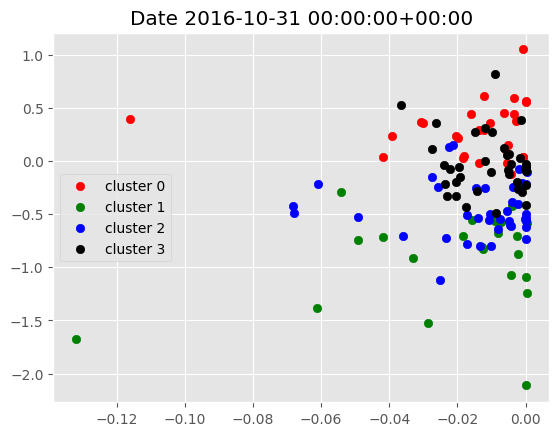

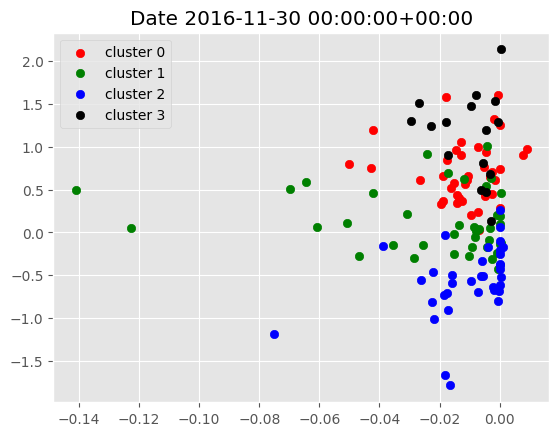

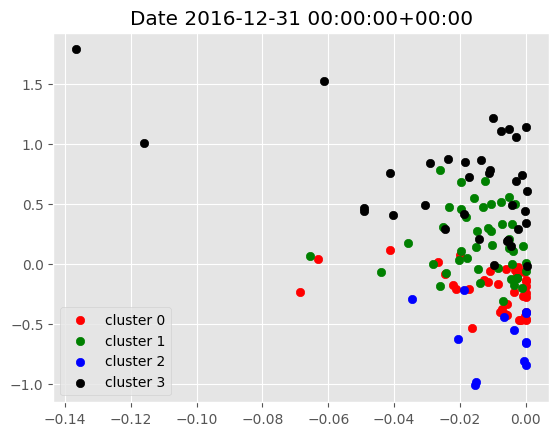

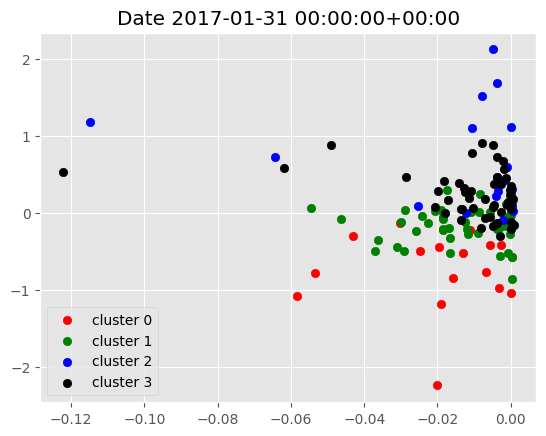

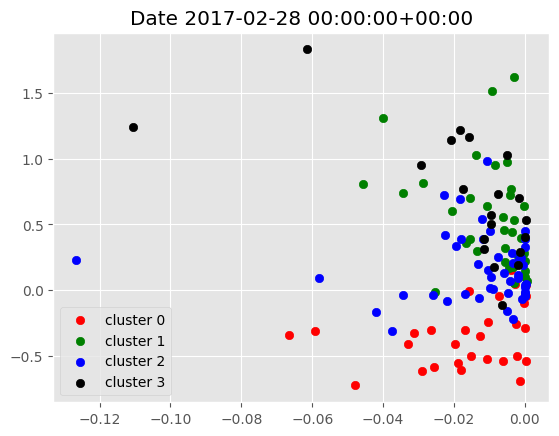

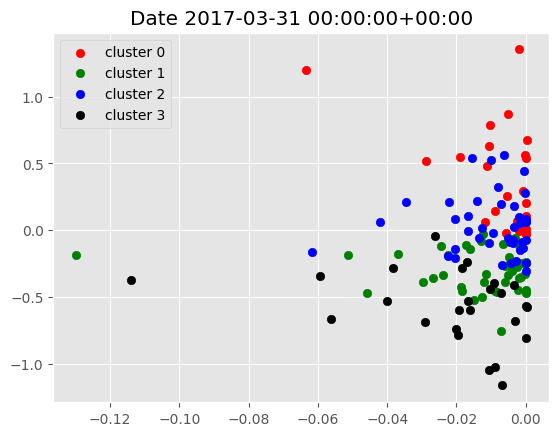

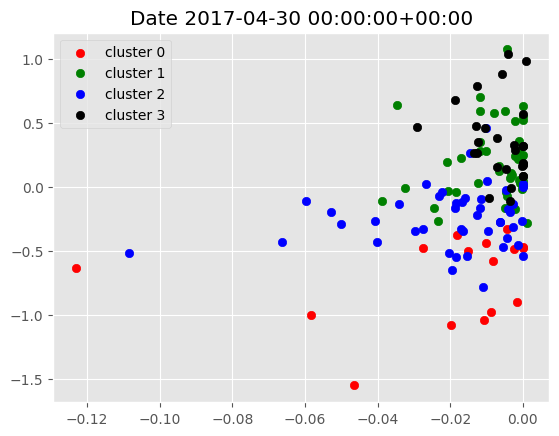

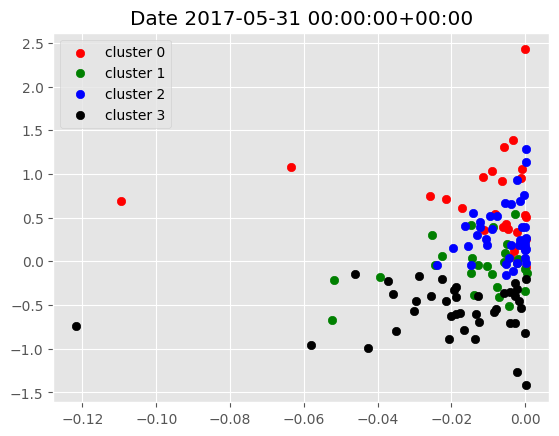

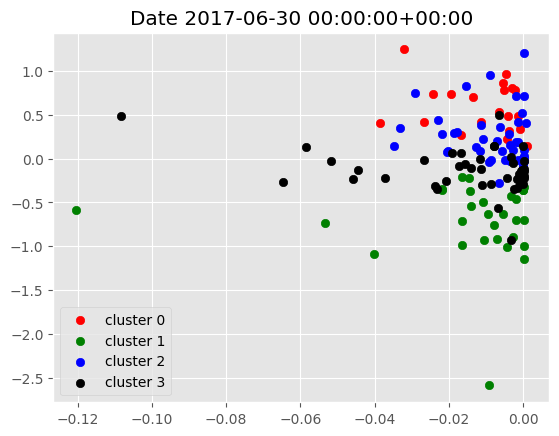

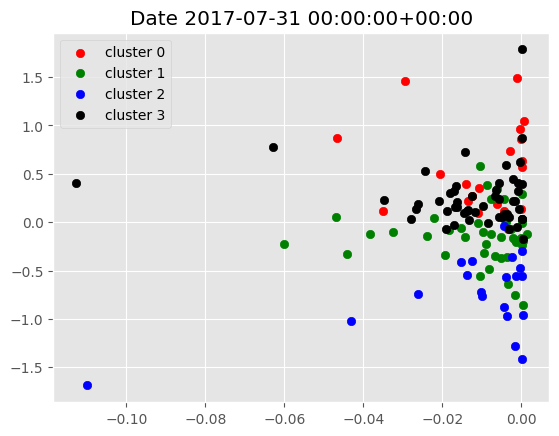

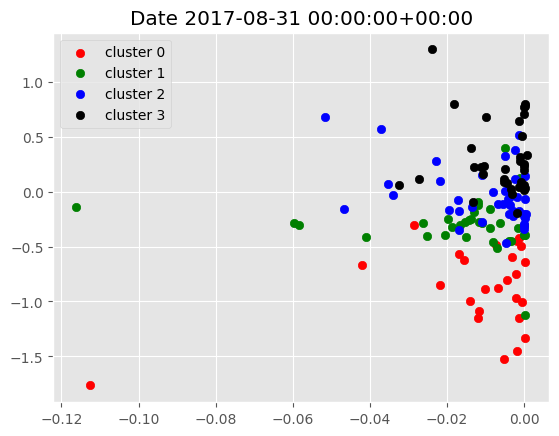

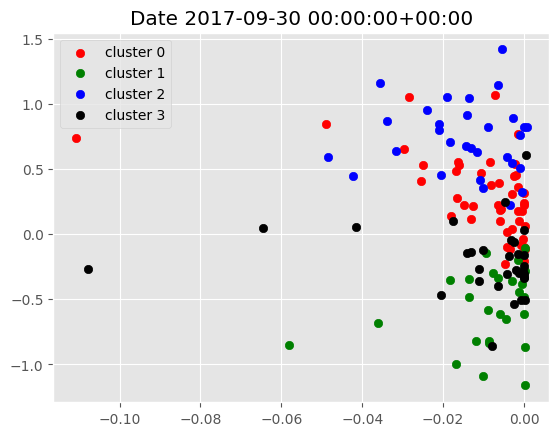

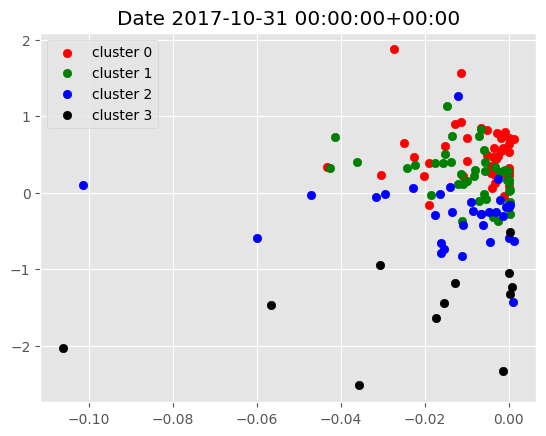

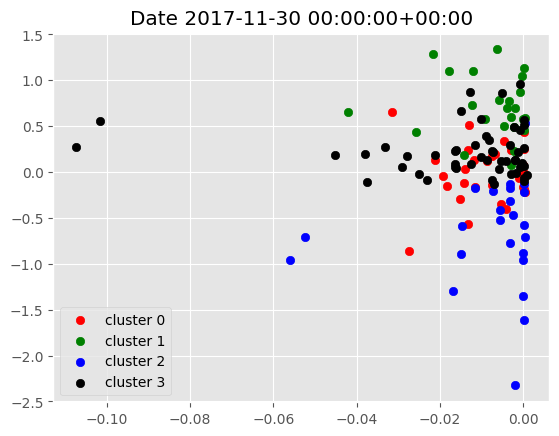

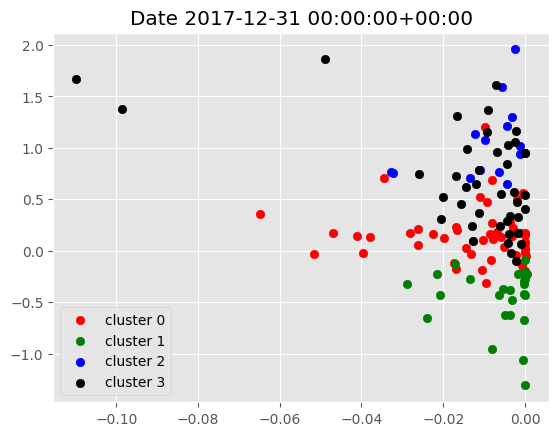

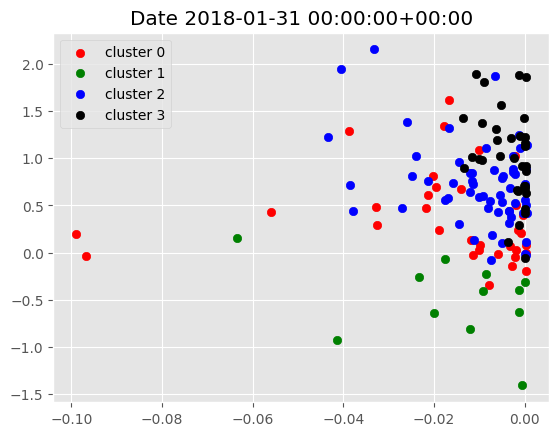

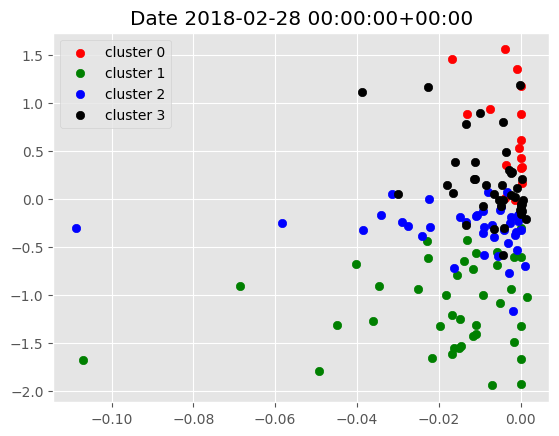

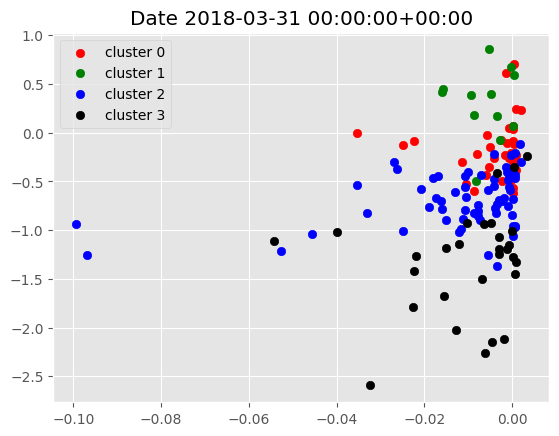

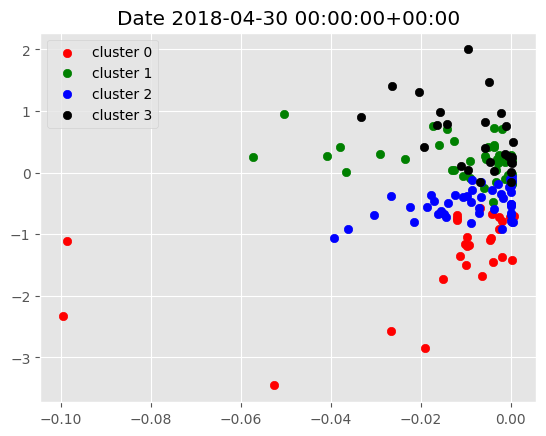

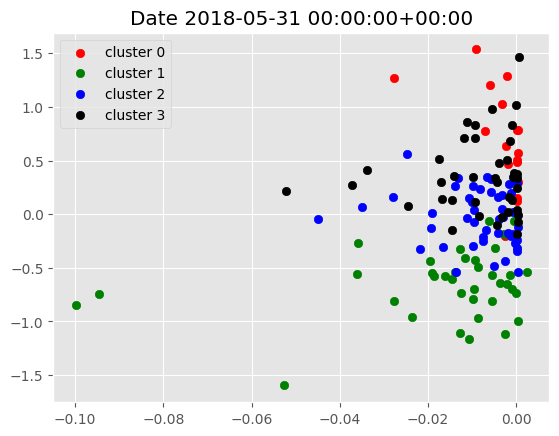

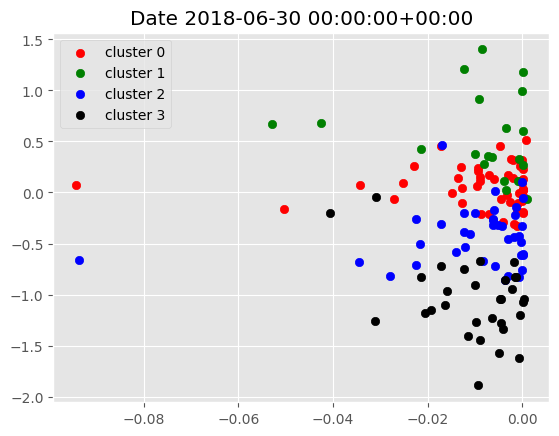

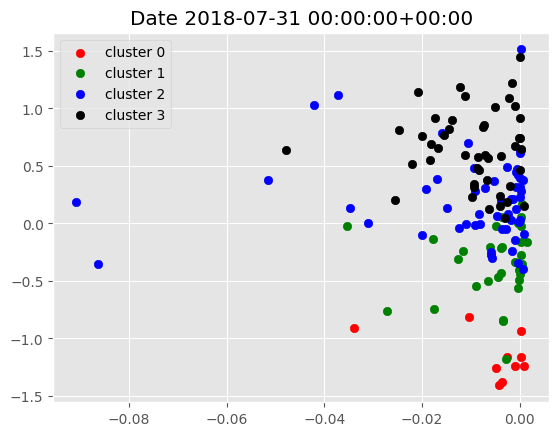

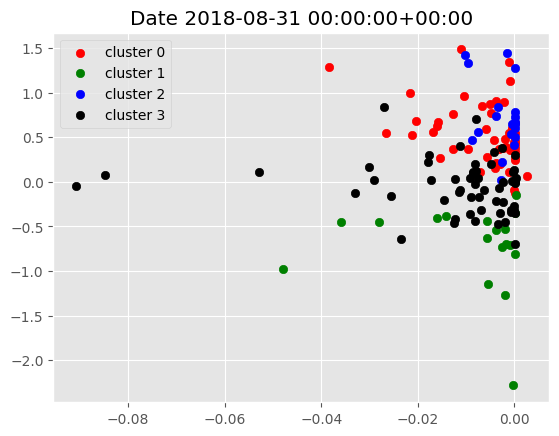

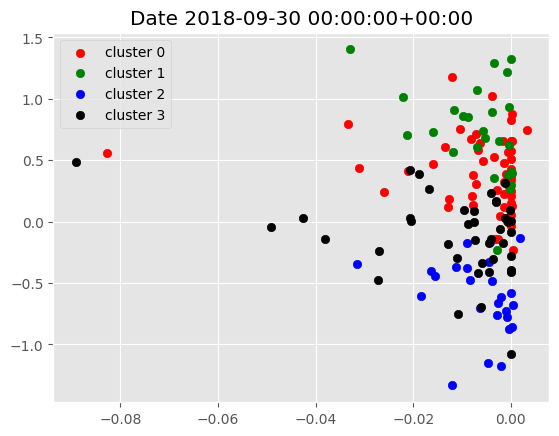

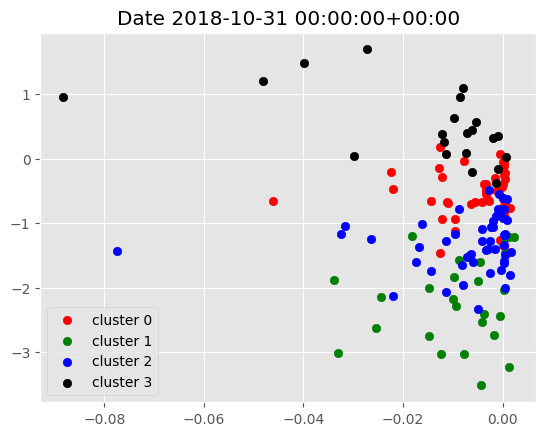

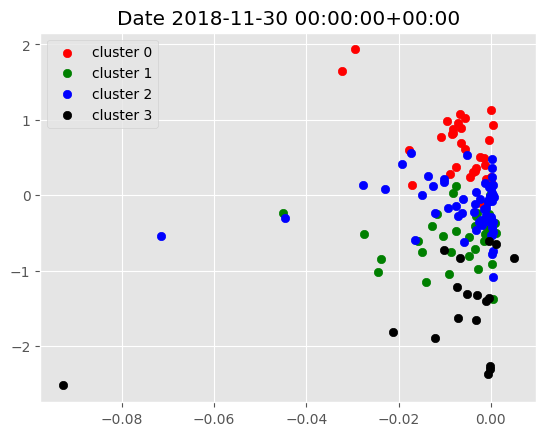

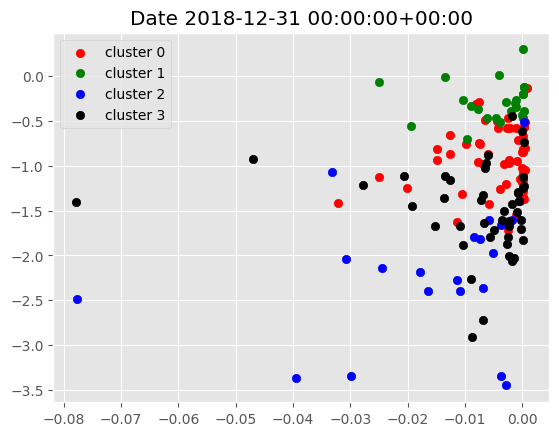

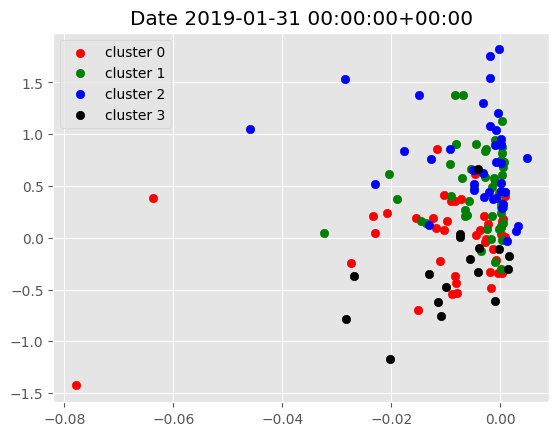

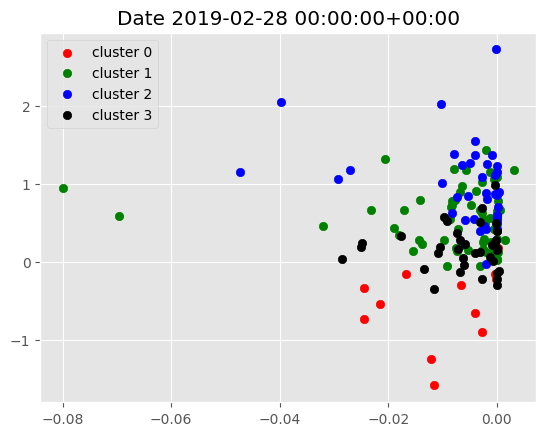

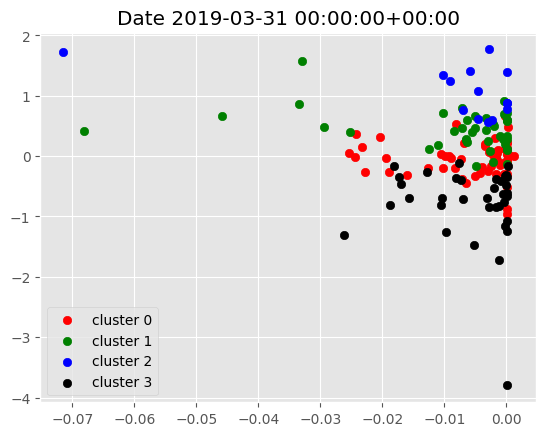

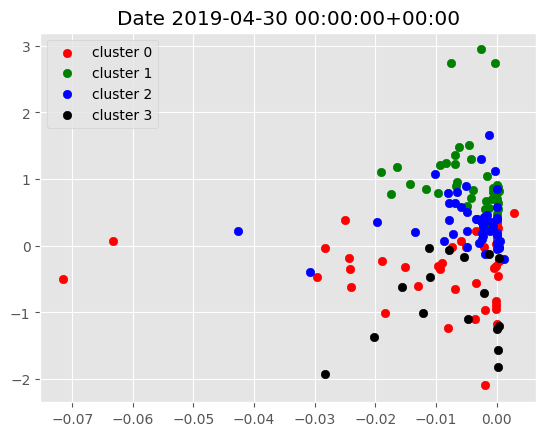

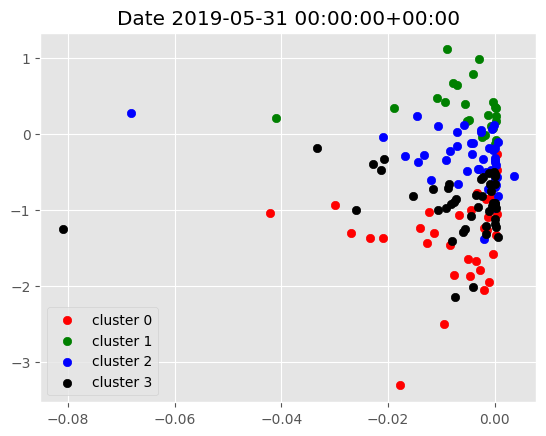

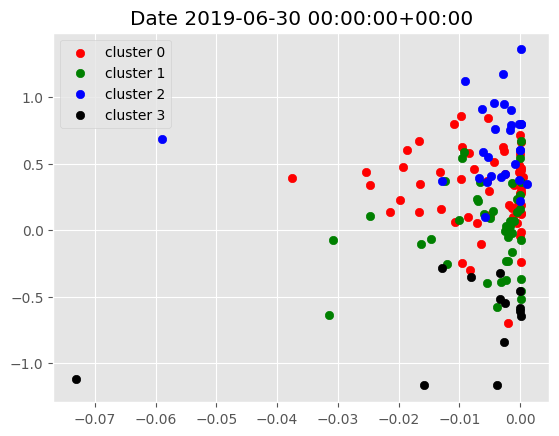

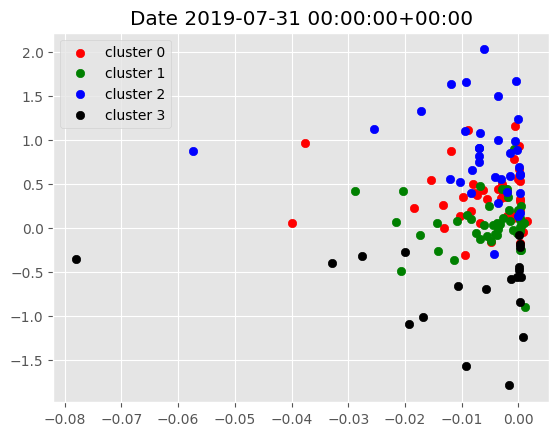

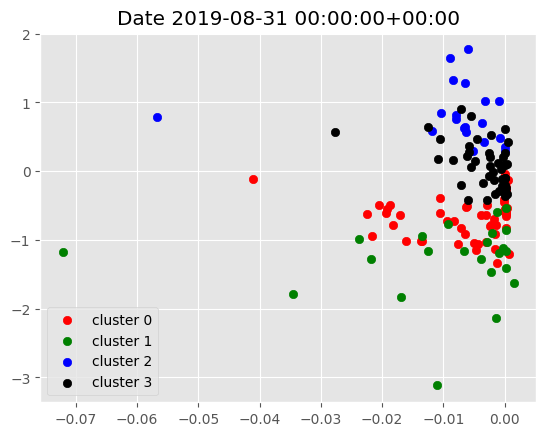

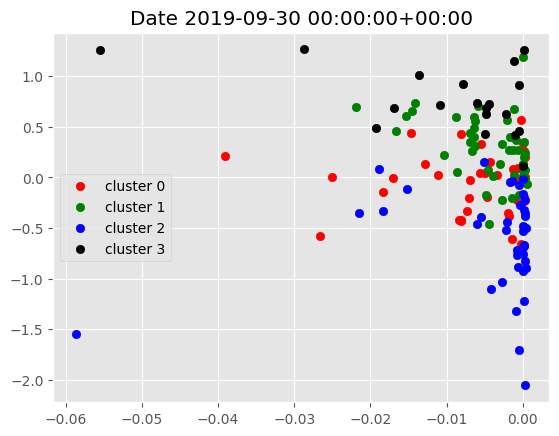

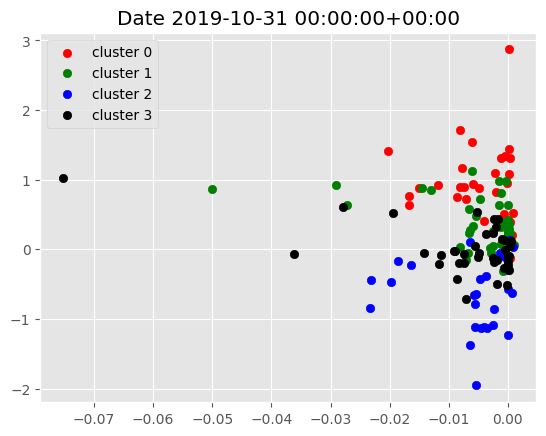

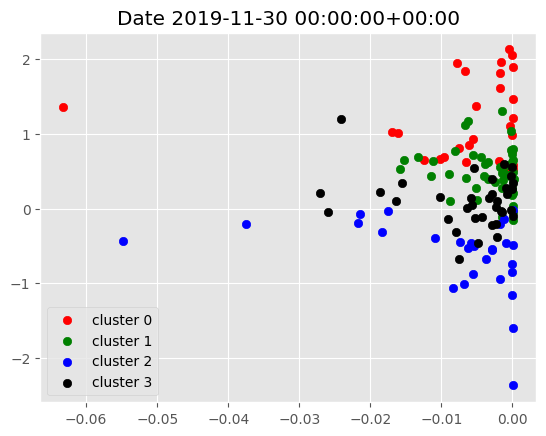

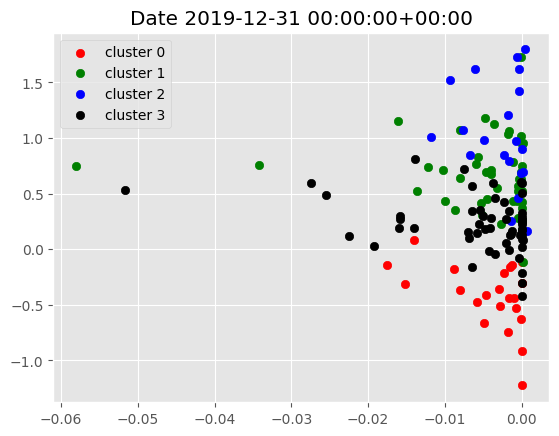

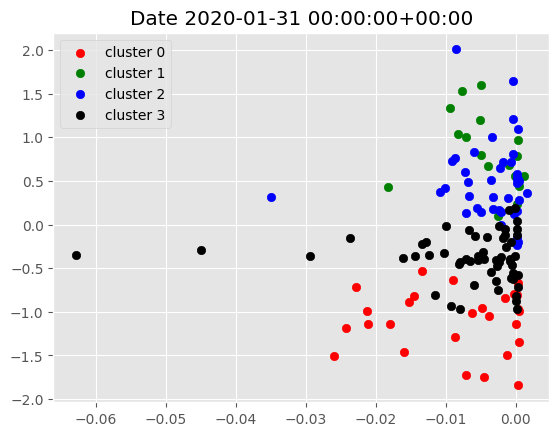

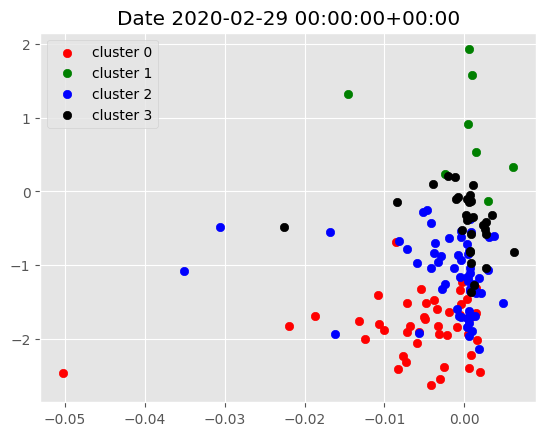

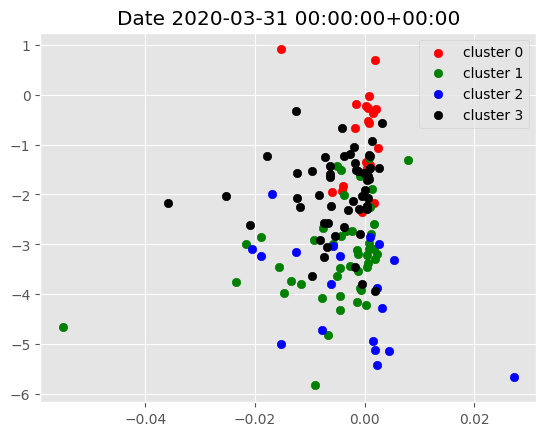

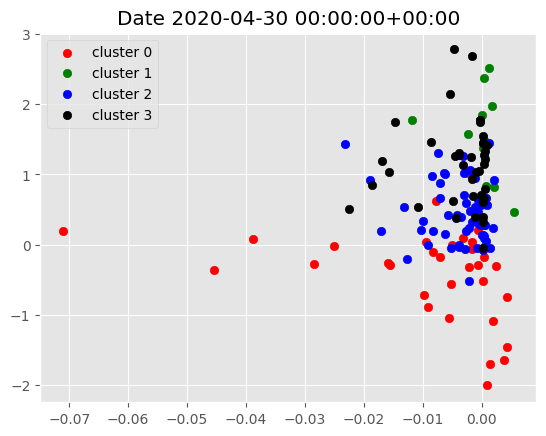

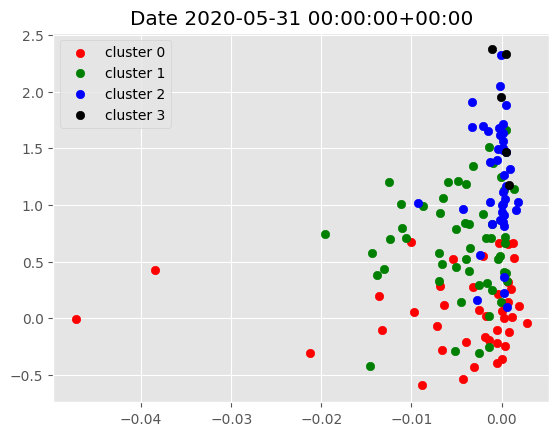

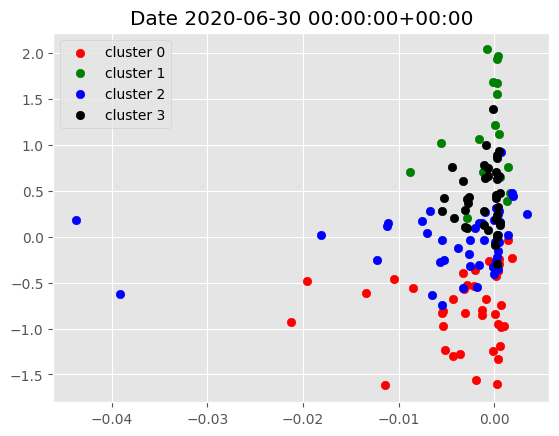

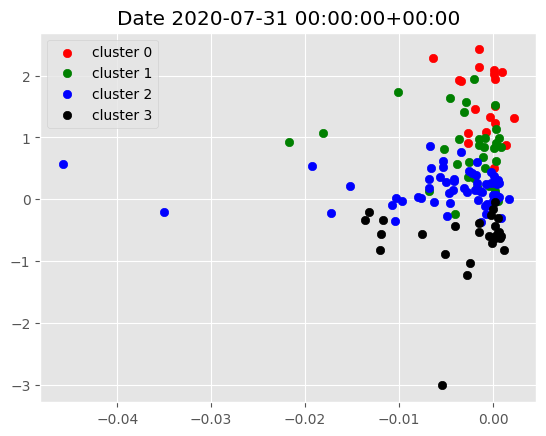

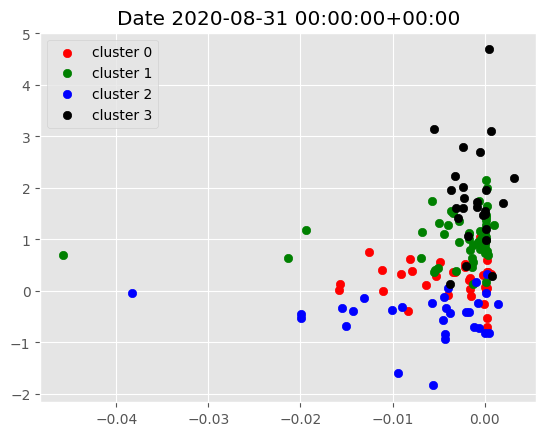

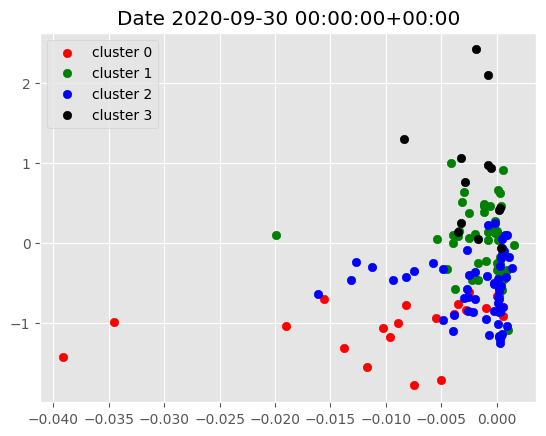

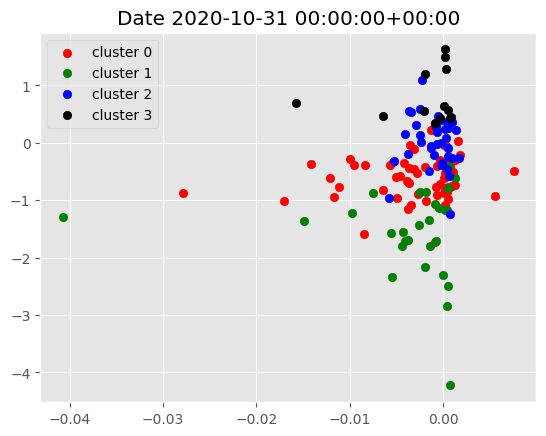

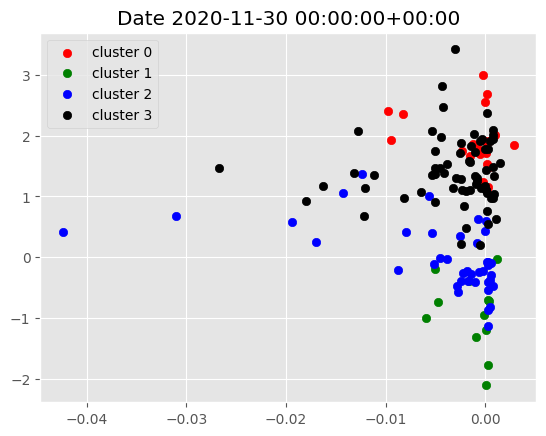

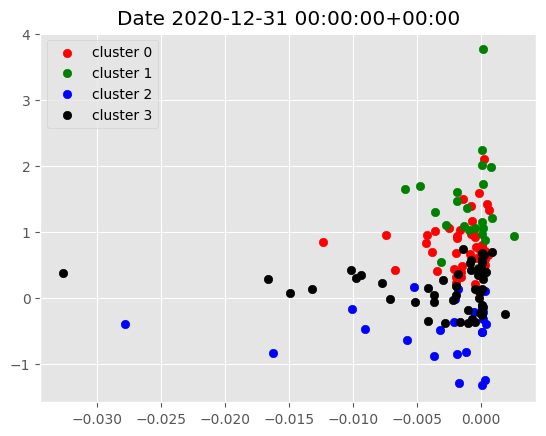

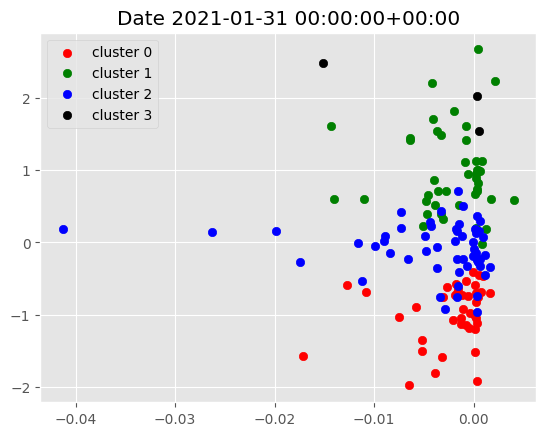

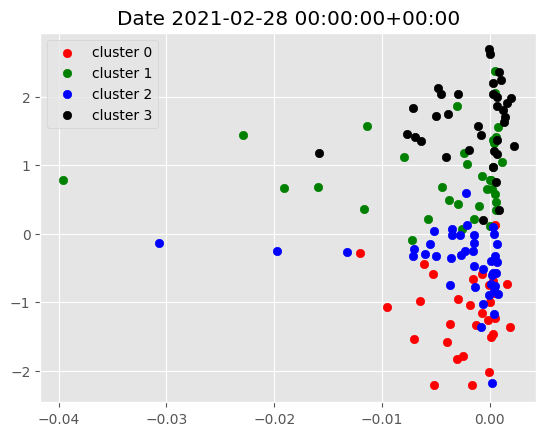

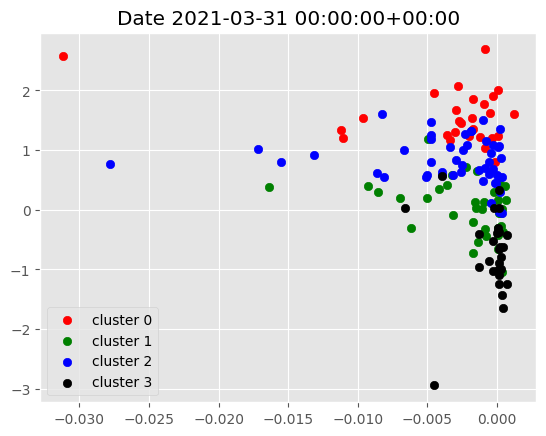

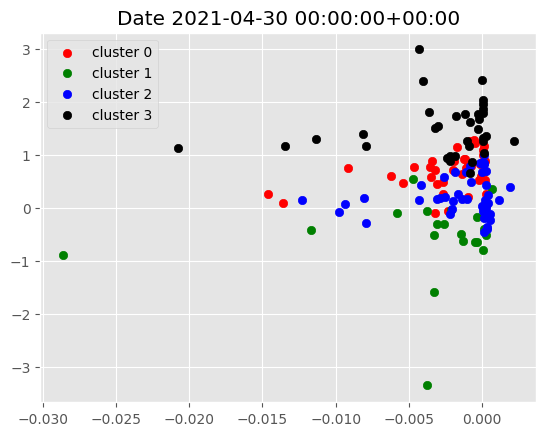

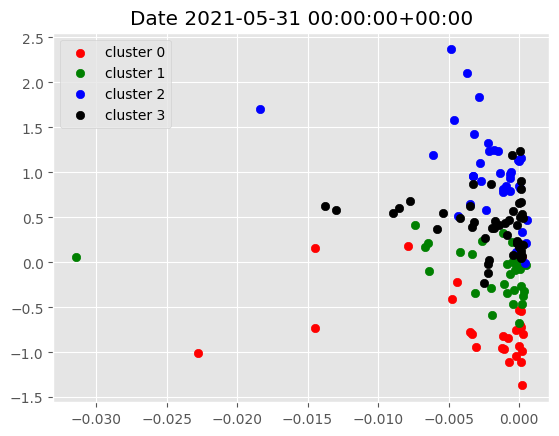

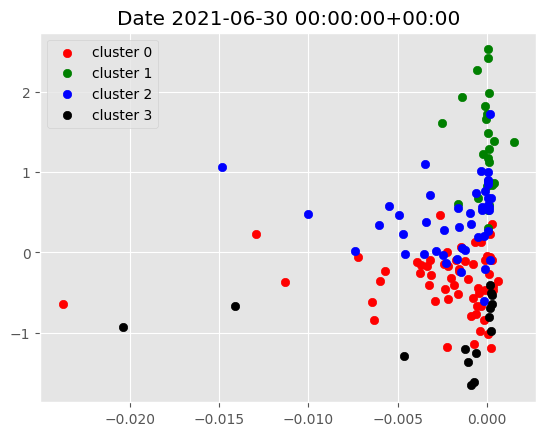

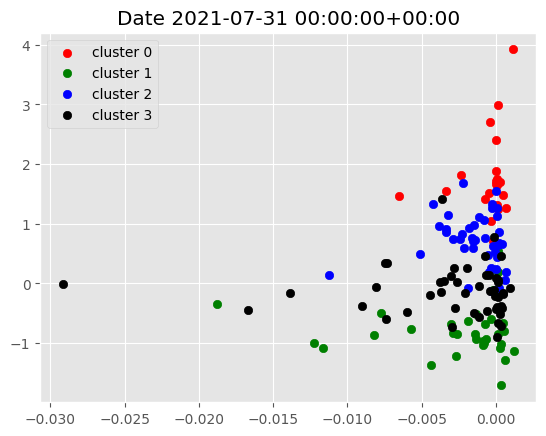

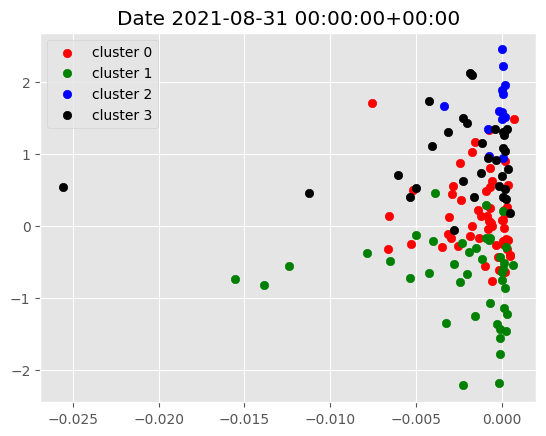

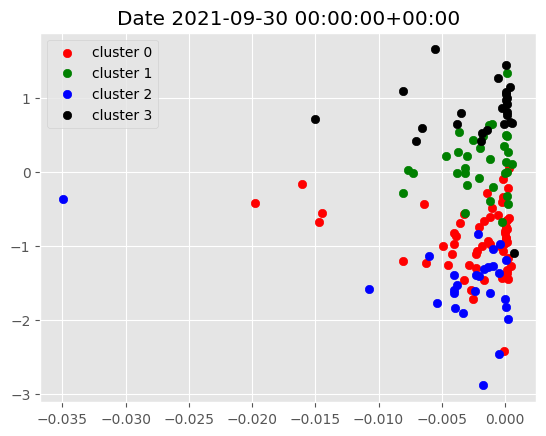

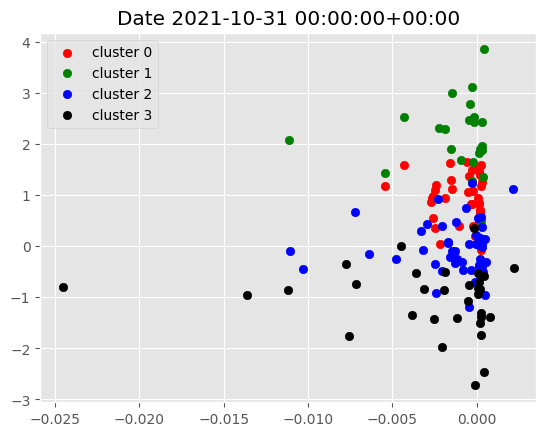

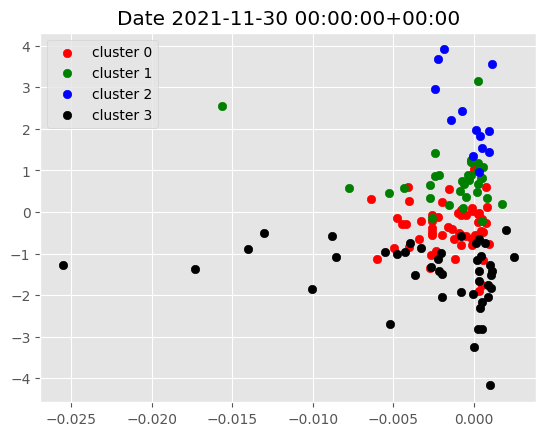

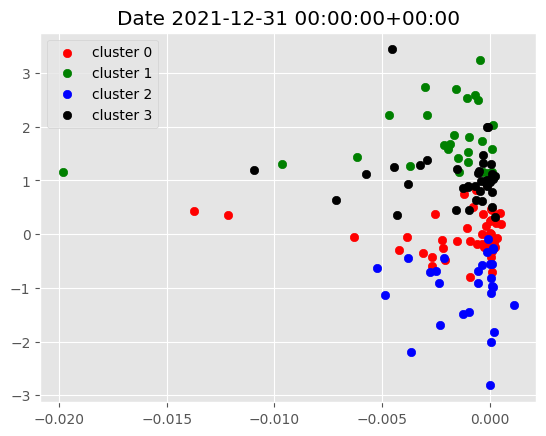

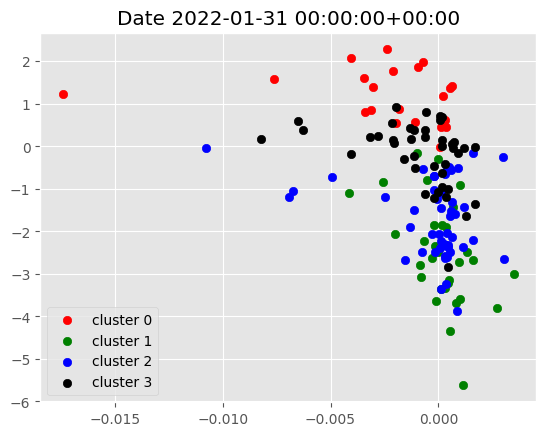

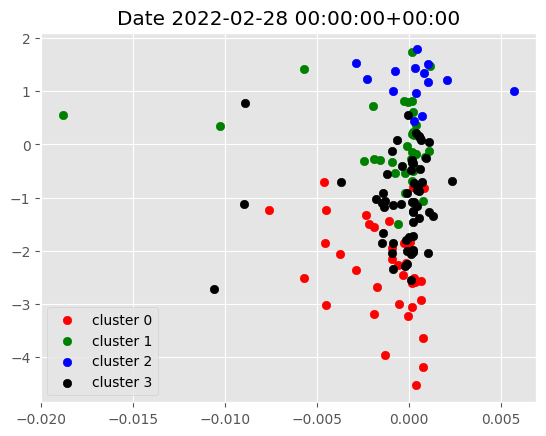

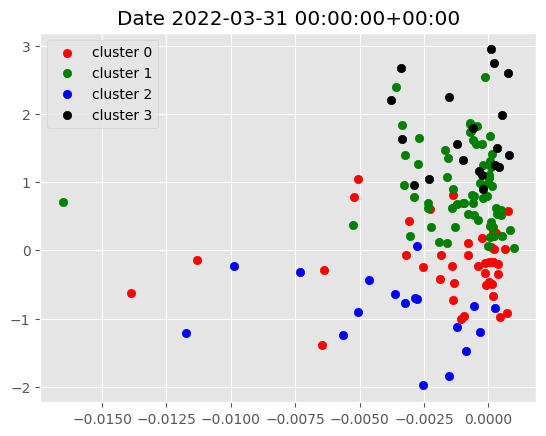

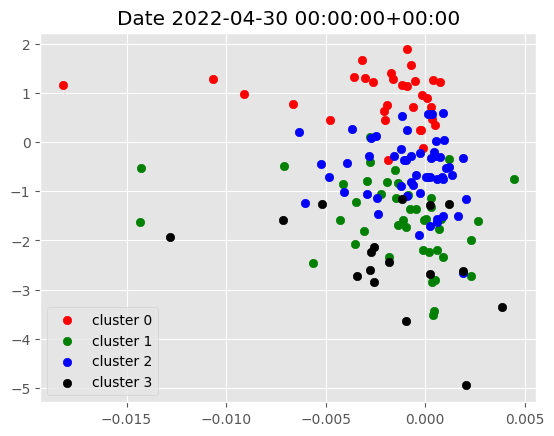

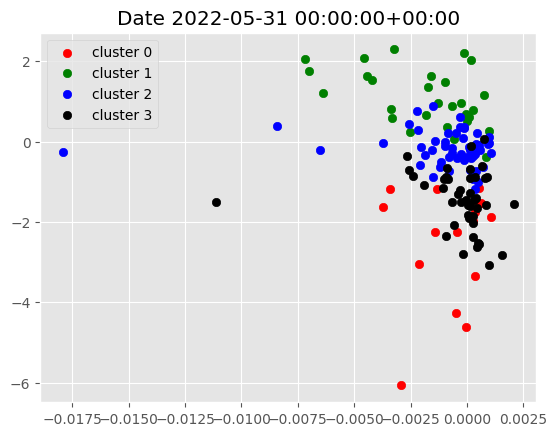

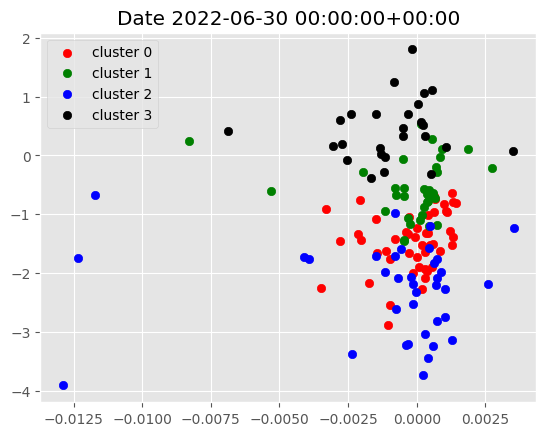

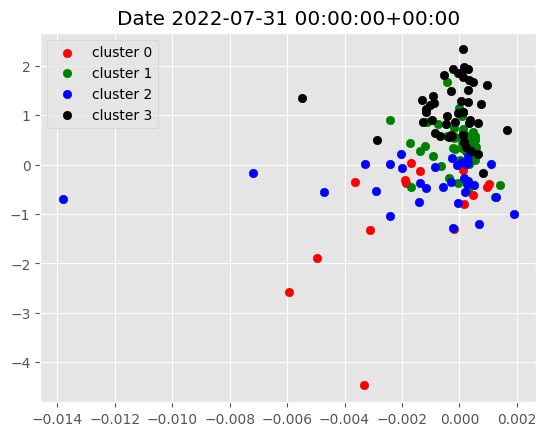

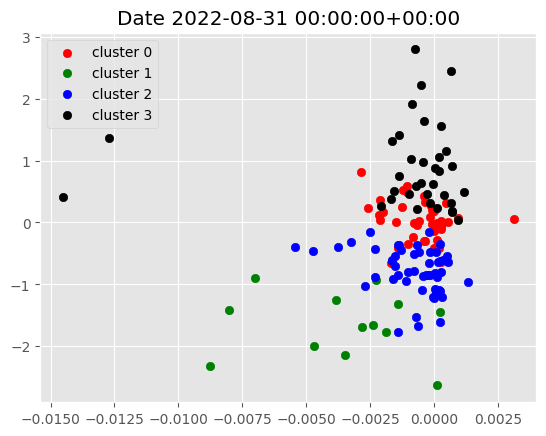

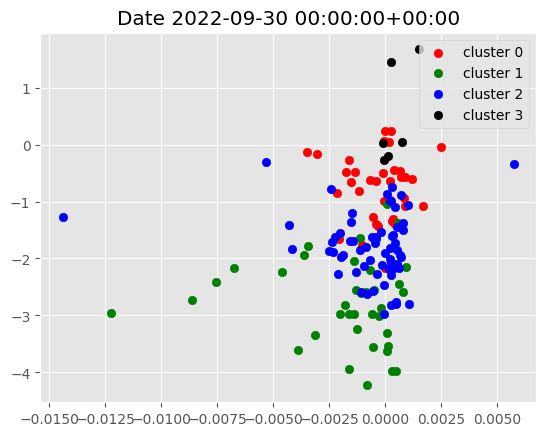

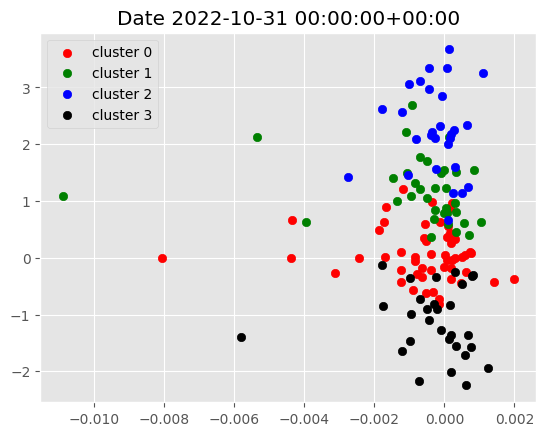

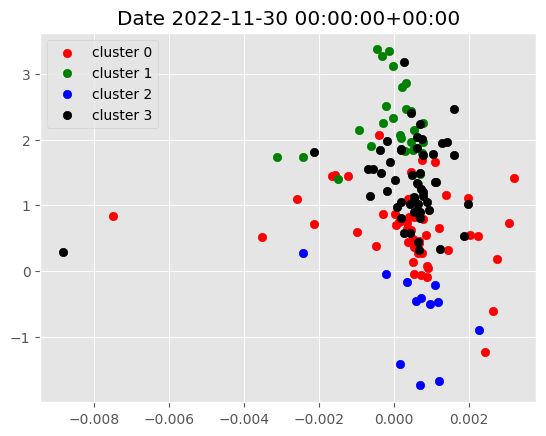

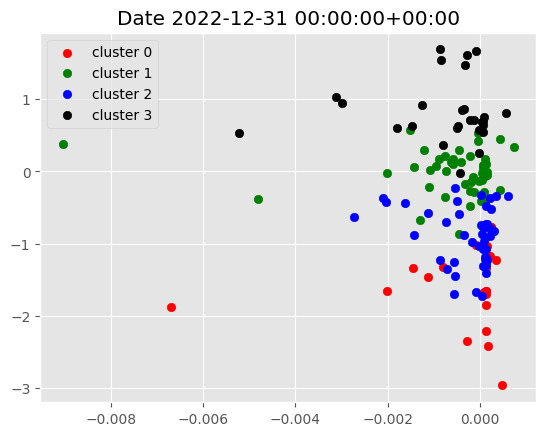

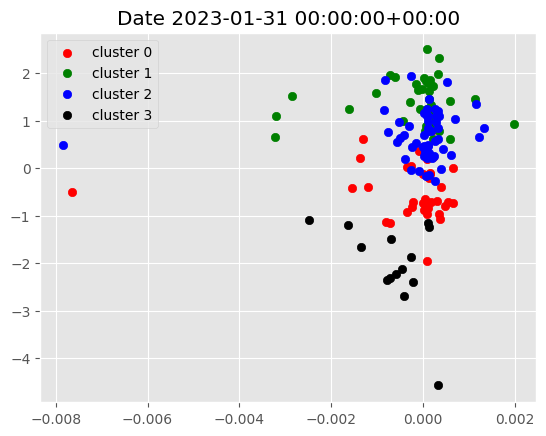

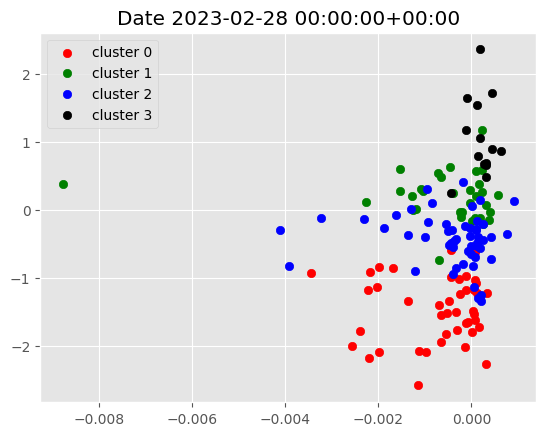

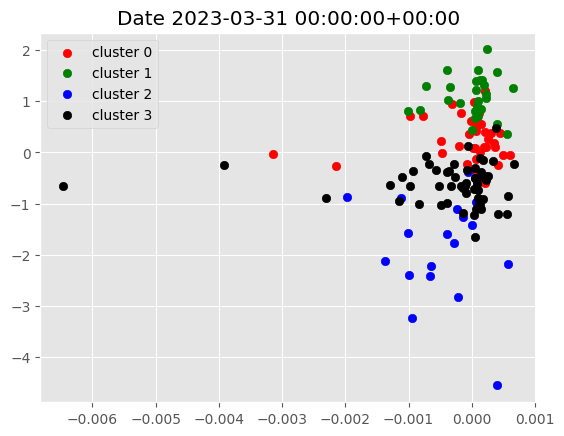

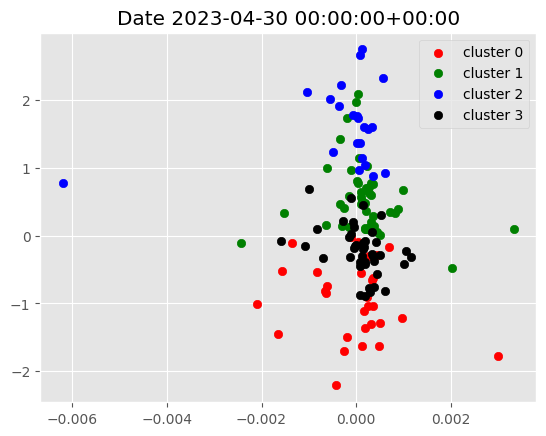

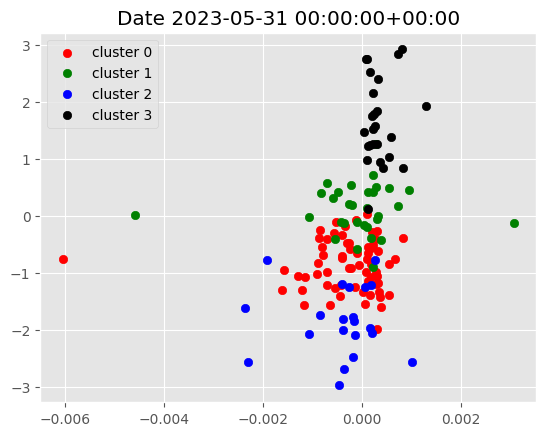

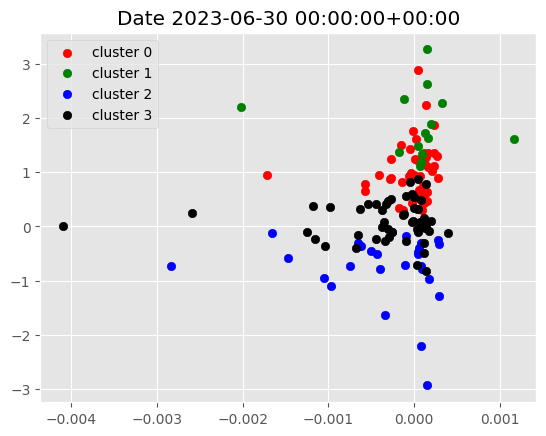

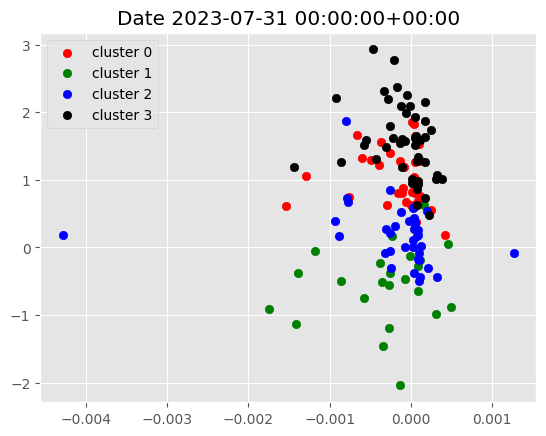

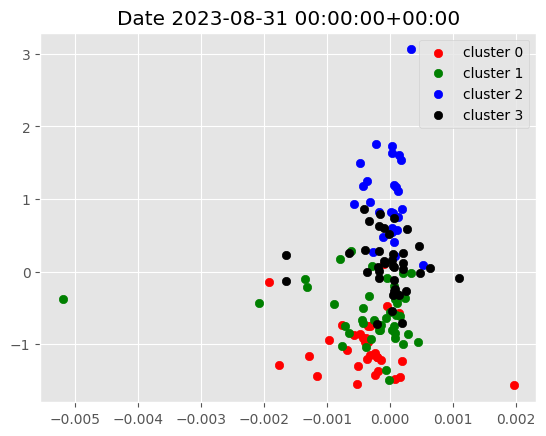

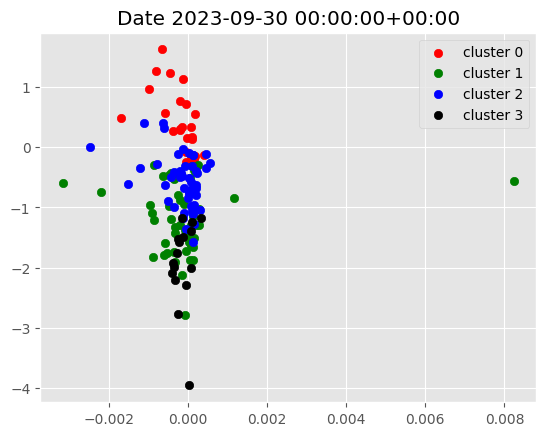

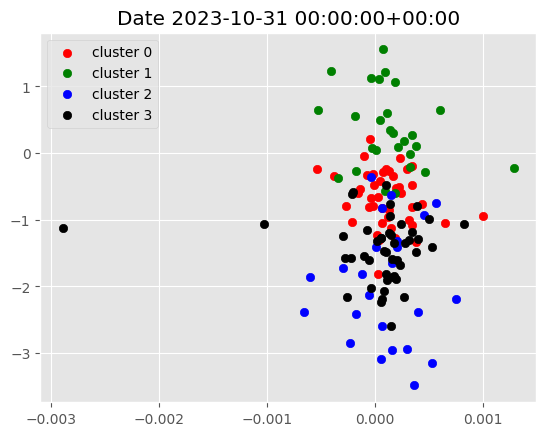

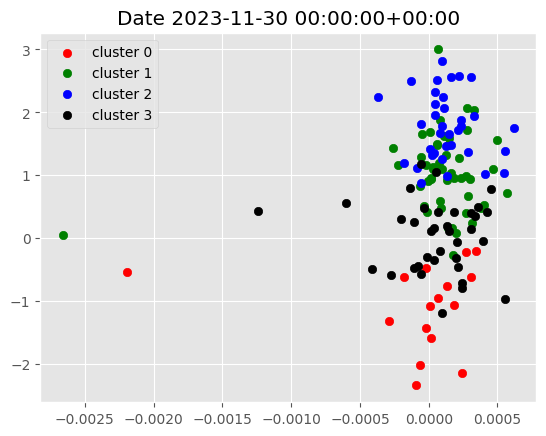

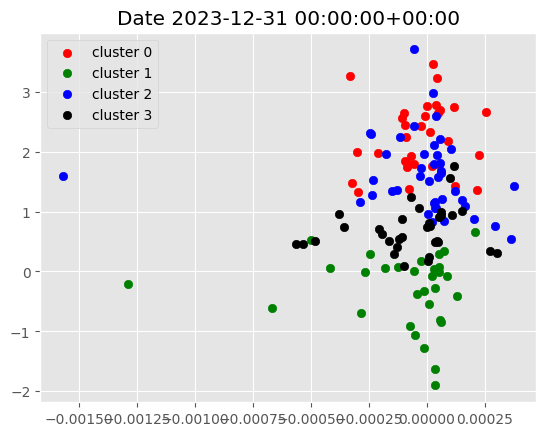

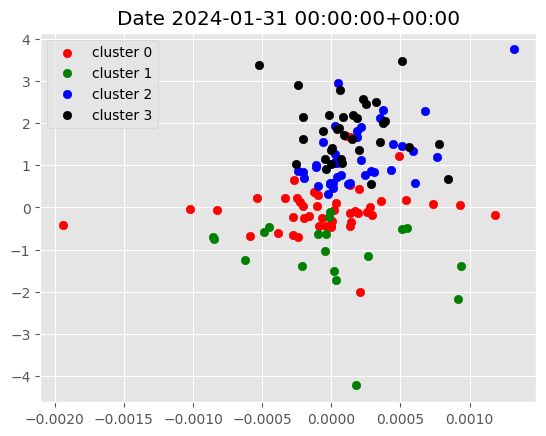

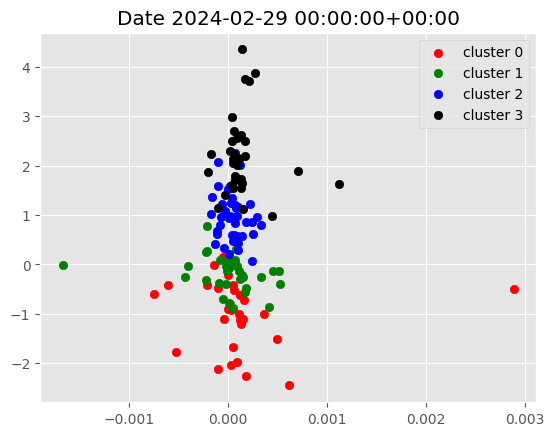

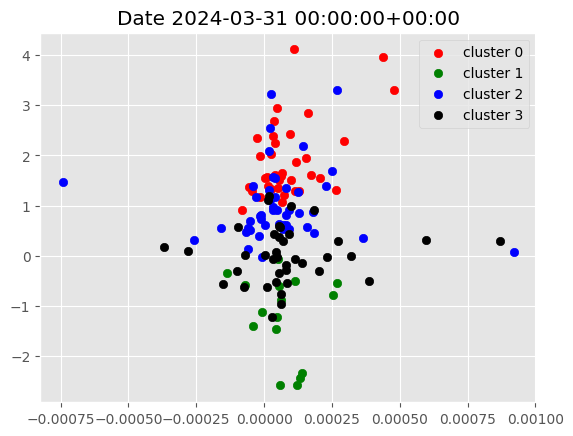

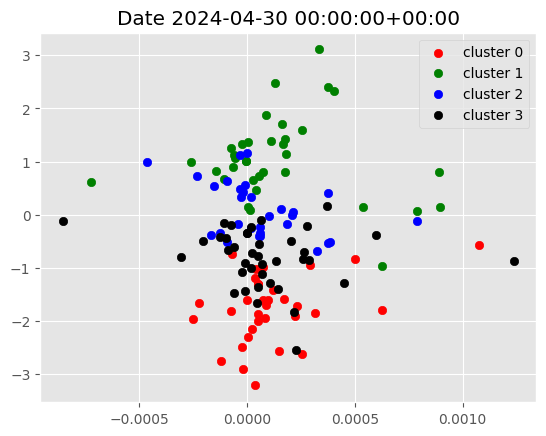

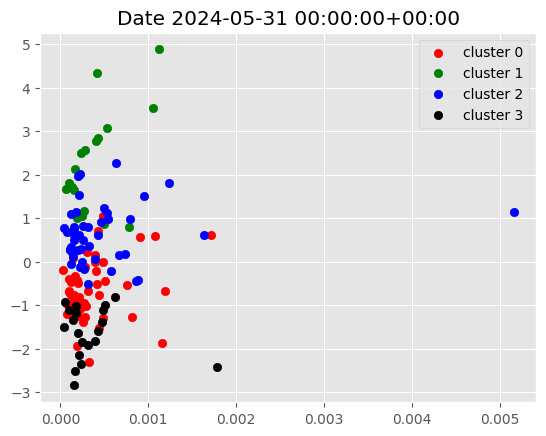

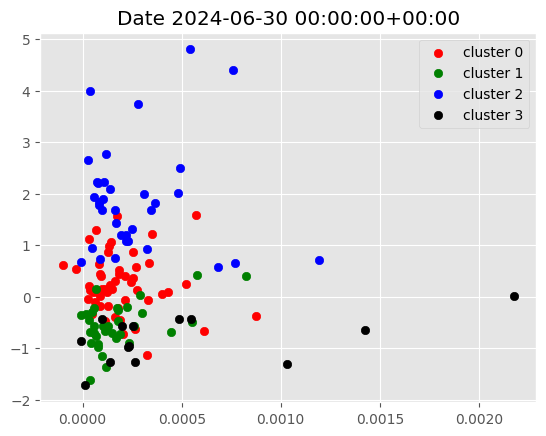

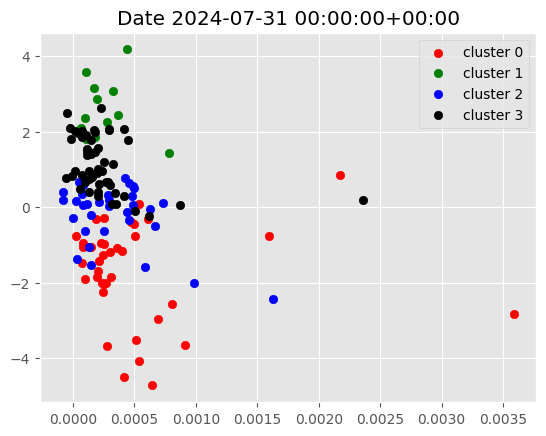

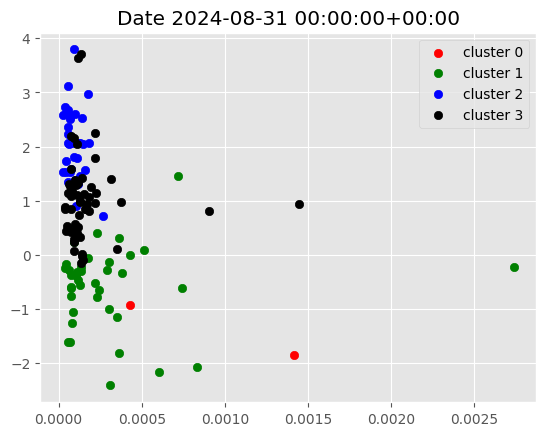

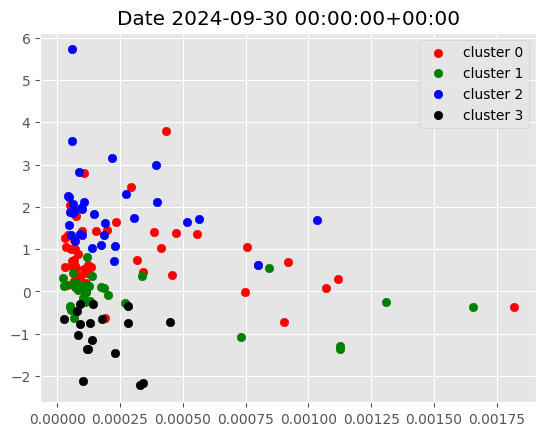

In [51]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

* Apply pre-defined centroids.

In [52]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

**7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization.**
* First I'll filter only stocks corresponding to the cluster I choose based on my hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [54]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2016-11-01': ['AAPL',
  'AMZN',
  'AVGO',
  'AZO',
  'BAX',
  'BMY',
  'BRK-B',
  'CAT',
  'CHTR',
  'CSCO',
  'CTSH',
  'DG',
  'DIS',
  'ELV',
  'EOG',
  'F',
  'GE',
  'GM',
  'GOOG',
  'GOOGL',
  'HCA',
  'HON',
  'HUM',
  'IBM',
  'JNJ',
  'KMI',
  'KO',
  'KR',
  'MCD',
  'ORCL',
  'OXY',
  'PG',
  'PM',
  'SBUX',
  'SLB',
  'TGT',
  'TJX',
  'TSLA',
  'UPS',
  'WFC',
  'WMT',
  'WYNN',
  'YUM'],
 '2016-12-01': ['AAPL',
  'ABBV',
  'ACN',
  'AIG',
  'AVGO',
  'AZO',
  'BKNG',
  'BMY',
  'CHTR',
  'CI',
  'CMG',
  'COST',
  'CTSH',
  'EXPE',
  'F',
  'GE',
  'HD',
  'HON',
  'KMI',
  'KR',
  'LOW',
  'MMM',
  'MO',
  'MSFT',
  'NFLX',
  'NXPI',
  'ORCL',
  'OXY',
  'PFE',
  'QCOM',
  'SHW',
  'SWKS',
  'T',
  'VLO',
  'VZ',
  'WBA',
  'WMT',
  'XOM',
  'YUM'],
 '2017-01-01': ['AAPL',
  'AIG',
  'AXP',
  'BA',
  'BAC',
  'BMY',
  'BRK-B',
  'C',
  'CHTR',
  'COF',
  'COP',
  'COST',
  'CSX',
  'DAL',
  'DD',
  'ELV',
  'GE',
  'HAL',
  'HD',
  'HUM',
  'IBM',
  'LUV',
  'MCD',
  

**Define portfolio optimization function**
* I'll define a function which optimizes portfolio weights using  [PyPortfolioOpt](https://pyportfolioopt.readthedocs.io/en/latest/GeneralEfficientFrontier.html) package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio I would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [55]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()

* Download Fresh Daily Prices Data only for short listed stocks.

In [56]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%***********************]  166 of 166 completed


Price                       Adj Close                                      \
Ticker                           AAPL        ABBV         ABT         ACN   
Date                                                                        
2015-11-02 00:00:00+00:00   27.358988   43.625759   38.523952   93.561646   
2015-11-03 00:00:00+00:00   27.672810   42.971859   38.591797   93.309441   
2015-11-04 00:00:00+00:00   27.544109   43.914852   38.311966   92.622543   
2015-11-05 00:00:00+00:00   27.417143   43.205879   38.311966   92.248657   
2015-11-06 00:00:00+00:00   27.448885   44.141991   38.693558   92.170395   
...                               ...         ...         ...         ...   
2024-09-23 00:00:00+00:00  226.470001  193.830002  114.809998  339.209991   
2024-09-24 00:00:00+00:00  227.369995  193.509995  113.339996  339.619995   
2024-09-25 00:00:00+00:00  226.369995  191.259995  112.610001  337.049988   
2024-09-26 00:00:00+00:00  227.520004  191.899994  112.730003  355.809998   
2024-09-27 00:00:00+00:00  227.789993  194.789993  112.430000  349.700012   

Price                                                                      \
Ticker                           ADBE         ADI         ADP        ADSK   
Date                                                                        
2015-11-02 00:00:00+00:00   89.910004   50.217186   71.630936   56.889999   
2015-11-03 00:00:00+00:00   90.360001   50.483494   71.416832   57.930000   
2015-11-04 00:00:00+00:00   91.010002   50.342018   71.606232   57.830002   
2015-11-05 00:00:00+00:00   90.550003   50.233818   71.622688   63.490002   
2015-11-06 00:00:00+00:00   90.690002   51.349026   72.157928   63.880001   
...                               ...         ...         ...         ...   
2024-09-23 00:00:00+00:00  527.869995  226.009995  277.579987  268.459991   
2024-09-24 00:00:00+00:00  524.070007  227.330002  276.640015  269.649994   
2024-09-25 00:00:00+00:00  517.900024  226.639999  275.250000  268.000000   
2024-09-26 00:00:00+00:00  515.380005  232.460007  274.429993  273.359985   
2024-09-27 00:00:00+00:00  515.479980  232.050003  272.880005  271.899994   

Price                                             ...   Volume            \
Ticker                           AIG        AMAT  ...     VRTX      VTRS   
Date                                              ...                      
2015-11-02 00:00:00+00:00  50.731411   15.135547  ...  1854700   9013000   
2015-11-03 00:00:00+00:00  48.518768   15.234120  ...  1811900  11600100   
2015-11-04 00:00:00+00:00  48.391434   15.117622  ...  1614400  10610000   
2015-11-05 00:00:00+00:00  49.346523   15.063852  ...  1485300   7093800   
2015-11-06 00:00:00+00:00  49.290817   15.278926  ...  2526400   6387800   
...                              ...         ...  ...      ...       ...   
2024-09-23 00:00:00+00:00  74.300003  194.039993  ...   975000  11824600   
2024-09-24 00:00:00+00:00  73.419998  196.779999  ...  1416400  10061300   
2024-09-25 00:00:00+00:00  73.019997  197.309998  ...   778200  19555100   
2024-09-26 00:00:00+00:00  73.120003  209.610001  ...   948200  10515800   
2024-09-27 00:00:00+00:00  73.339996  204.919998  ...   710700   6370700   

Price                                                                       \
Ticker                           VZ       WBA      WDC       WFC       WMT   
Date                                                                         
2015-11-02 00:00:00+00:00  11689100   6950300  3486000  10992300  32157600   
2015-11-03 00:00:00+00:00  11900900   7044100  4750500  10709100  30761700   
2015-11-04 00:00:00+00:00   9702000   5484800  4621800  12823600  30169500   
2015-11-05 00:00:00+00:00  11646900   3550400  3843300  12263900  26581500   
2015-11-06 00:00:00+00:00  14144400   6129100  2850600  22376800  29931900   
...                             ...       ...      ...       ...       ...   
2024-09-23 00:00:00+00:00  18083200  15926200  2908200  14759300  12147300 

* Calculate daily returns for each stock which could land up in my portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [66]:
from sre_constants import SUCCESS
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
  try:
    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
    cols = fixed_dates[start_date]
    optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).date().strftime('%Y-%m-%d')
    optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]

    SUCCESS = False

    try:
      weights = optimize_weights(prices=optimization_df, lower_bound=round(1/(len(optimization_df.columns)*2),3))
      weights = pd.DataFrame(weights, index=pd.Series(0))
      SUCCESS = True

    except:
      print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')

    if SUCCESS==False:
      weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                      index=optimization_df.columns.tolist(),
                                      columns=pd.Series(0)).T

    temp_df = returns_dataframe[start_date:end_date]
    temp_df.index = temp_df.index.date
    temp_df = temp_df.stack().reset_index()
    temp_df.columns = ['Date', 'ticker', 'return']

    # Reset index of weights and rename columns to match temp_df for merging
    weights = weights.stack().reset_index()
    weights.columns = ['dummy', 'ticker', 'weight']
    weights = weights.drop('dummy', axis=1)

    # Merge temp_df and weights on 'ticker'
    temp_df = temp_df.merge(weights, on='ticker')

    # Set 'Date' and 'ticker' as index to remove the unwanted column
    temp_df = temp_df.set_index(['Date', 'ticker'])

    temp_df.unstack().stack()

    temp_df['weighted_return'] = temp_df['return']*temp_df['weight']
    temp_df=temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy_return')
    portfolio_df = pd.concat([portfolio_df, temp_df])

  except Exception as e:
          print(e)

portfolio_df = portfolio_df.drop_duplicates()
portfolio_df

Max Sharpe Optimization failed for 2022-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2023-11-01, Continuing with Equal-Weights


Strategy_return
Date                       
2016-11-01        -0.006987
2016-11-02        -0.000439
2016-11-03        -0.006601
2016-11-04        -0.001274
2016-11-07         0.021426
...                     ...
2024-09-23         0.000880
2024-09-24         0.001994
2024-09-25        -0.003720
2024-09-26         0.000989
2024-09-27        -0.003021

[1989 rows x 1 columns]

<Axes: xlabel='Date'>

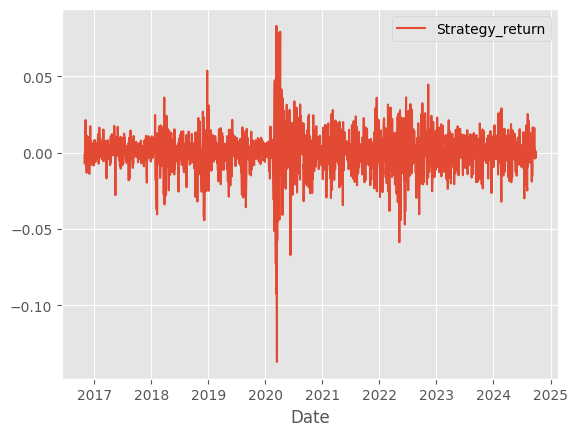

In [67]:
portfolio_df.plot()

**8. Visualize Portfolio returns and compare to SP500 returns.**

In [68]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy & Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


Strategy_return  SPY Buy & Hold
Date                                       
2016-11-01        -0.006987       -0.007272
2016-11-02        -0.000439       -0.006037
2016-11-03        -0.006601       -0.004588
2016-11-04        -0.001274       -0.001102
2016-11-07         0.021426        0.021817
...                     ...             ...
2024-09-23         0.000880        0.002496
2024-09-24         0.001994        0.002857
2024-09-25        -0.003720       -0.002208
2024-09-26         0.000989        0.003957
2024-09-27        -0.003021       -0.001451

[1989 rows x 2 columns]

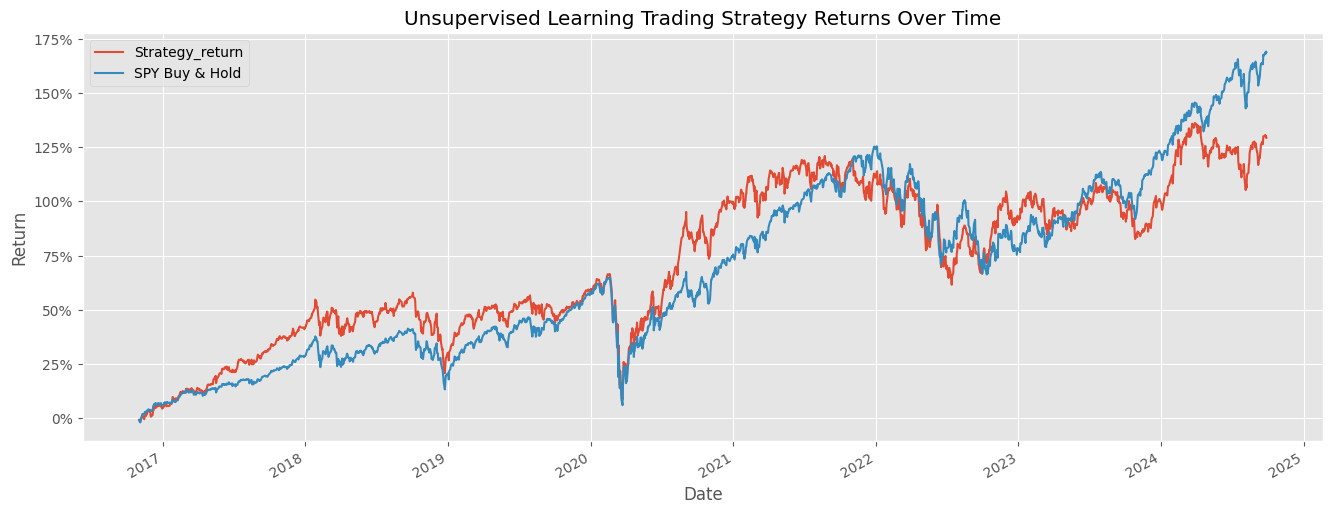

In [72]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

# Twitter Sentiment Investing Strategy



**1. Load Twitter Sentiment Data**
* Load the twitter sentiment dataset, set the index, calculat engagement ratio and filter out stocks with no significant twitter activity.

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf
import os

plt.style.use('ggplot')

data_folder = '/content/sentiment_data.csv'

sentiment_df = pd.read_csv(data_folder)

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

sentiment_df = sentiment_df.set_index(['date', 'symbol'])

sentiment_df['engagement_ratio'] = sentiment_df['twitterComments']/sentiment_df['twitterLikes']

sentiment_df = sentiment_df[(sentiment_df['twitterLikes']>20)&(sentiment_df['twitterComments']>10)]

sentiment_df

twitterPosts  twitterComments  twitterLikes  \
date       symbol                                                
2021-11-18 AAPL           811.0           2592.0       21674.0   
           AMD            150.0            675.0        2949.0   
           AMZN           557.0           1315.0       12969.0   
           ATVI            82.0             36.0         131.0   
           BA              61.0             55.0         342.0   
...                         ...              ...           ...   
2023-01-04 T              184.0           3409.0       14271.0   
           TSLA          6767.0         540711.0     3810688.0   
           TSN             35.0            168.0         460.0   
           V              132.0           1008.0        5943.0   
           XOM            212.0            374.0        2071.0   

                   twitterImpressions  twitterSentiment  engagement_ratio  
date       symbol                                                          
2021-11-18 AAPL             7981808.0               NaN          0.119590  
           AMD              1645270.0               NaN          0.228891  
           AMZN             5590695.0               NaN          0.101396  
           ATVI             1310715.0               NaN          0.274809  
           BA                425847.0               NaN          0.160819  
...                               ...               ...               ...  
2023-01-04 T                 884935.0          0.590457          0.238876  
           TSLA            55464921.0          0.543057          0.141893  
           TSN                57207.0          0.561900          0.365217  
           V                 139835.0          0.567286          0.169611  
           XOM               483389.0          0.588914          0.180589  

[25375 rows x 6 columns]

**2. Aggregate Monthly and calculate average sentiment for the month**
* Aggregate on a monthly level and calculate average monthly metric, for the one I choose.


In [78]:
aggragated_df = (sentiment_df.reset_index('symbol').groupby([pd.Grouper(freq='M'), 'symbol'])
                    [['engagement_ratio']].mean())

aggragated_df['rank'] = (aggragated_df.groupby(level=0)['engagement_ratio']
                         .transform(lambda x: x.rank(ascending=False)))

aggragated_df

engagement_ratio  rank
date       symbol                        
2021-11-30 AAL             0.203835  37.0
           AAPL            0.256318  23.0
           ABBV            0.244677  26.0
           ABT             0.313368  14.0
           AES             0.864613   2.0
...                             ...   ...
2023-01-31 TMO             0.333313  19.0
           TSLA            0.151992  72.0
           TSN             0.280553  30.0
           V               0.194045  60.0
           XOM             0.217904  53.0

[1109 rows x 2 columns]

**3. Select Top 5 Stocks based on their cross-sectional ranking for each month**
* Select top 5 stocks by rank for each month and fix the date to start at beginning of next month.


In [79]:
filtered_df = aggragated_df[aggragated_df['rank']<6].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'symbol'])

filtered_df.head(20)

engagement_ratio  rank
date       symbol                        
2021-12-01 AES             0.864613   2.0
           FCX             0.626323   5.0
           MNST            0.699721   3.0
           OXY             2.147741   1.0
           SLB             0.647374   4.0
2022-01-01 D               0.801994   5.0
           FCX             0.841220   4.0
           L               6.507246   1.0
           LUV             1.303215   2.0
           MA              0.883401   3.0
2022-02-01 AMD             0.715556   4.0
           D               1.136678   1.0
           FCX             0.655237   5.0
           LUV             1.035258   2.0
           MA              0.729063   3.0
2022-03-01 FCX             1.138332   2.0
           GILD            0.530886   5.0
           LUV             1.574377   1.0
           MRO             0.581748   4.0
           OXY             1.025579   3.0

**4. Extract the stocks to form portfolios with at the start of each new month**
* Create a dictionary containing start of month and corresponded selected stocks.


In [80]:
dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2021-12-01': ['AES', 'FCX', 'MNST', 'OXY', 'SLB'],
 '2022-01-01': ['D', 'FCX', 'L', 'LUV', 'MA'],
 '2022-02-01': ['AMD', 'D', 'FCX', 'LUV', 'MA'],
 '2022-03-01': ['FCX', 'GILD', 'LUV', 'MRO', 'OXY'],
 '2022-04-01': ['A', 'CRM', 'PFE', 'PM', 'STZ'],
 '2022-05-01': ['AMD', 'CRM', 'CVX', 'J', 'KEY'],
 '2022-06-01': ['AMD', 'DD', 'FCX', 'KEY', 'LMT'],
 '2022-07-01': ['CB', 'CRM', 'DD', 'FCX', 'STZ'],
 '2022-08-01': ['A', 'DD', 'JPM', 'REGN', 'STZ'],
 '2022-09-01': ['ABT', 'DIS', 'L', 'META', 'MRNA'],
 '2022-10-01': ['J', 'KEY', 'L', 'META', 'MU'],
 '2022-11-01': ['A', 'DD', 'FCX', 'J', 'META'],
 '2022-12-01': ['AEP', 'AES', 'DD', 'J', 'STZ'],
 '2023-01-01': ['A', 'AES', 'DAL', 'J', 'KEY'],
 '2023-02-01': ['A', 'AES', 'BIIB', 'FCX', 'MDT']}

**5. Download fresh stock prices for only selected/shortlisted stocks**


In [87]:
stocks_list = sentiment_df.index.get_level_values('symbol').unique().tolist()
print(stocks_list.remove('ATVI'))
prices_df = yf.download(tickers=stocks_list,
                        start='2021-01-01',
                        end='2023-03-01')

None


[*********************100%***********************]  84 of 84 completed


**6. Calculate Portfolio Returns with monthly rebalancing**


In [92]:
returns_df = np.log(prices_df['Adj Close']).diff().dropna()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():

    end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd()).strftime('%Y-%m-%d')

    cols = fixed_dates[start_date]

    temp_df = returns_df[start_date:end_date][cols].mean(axis=1).to_frame('portfolio_return')

    portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)

portfolio_df.index = portfolio_df.index.date
portfolio_df

portfolio_return
2021-12-01         -0.016417
2021-12-02          0.024872
2021-12-03         -0.007711
2021-12-06          0.023926
2021-12-07          0.030547
...                      ...
2023-02-22         -0.007870
2023-02-23         -0.007323
2023-02-24         -0.009463
2023-02-27         -0.001871
2023-02-28          0.001403

[312 rows x 1 columns]

**7. Download NASDAQ/QQQ prices and calculate returns to compare to my strategy**


In [93]:
qqq_df = yf.download(tickers='QQQ',
                     start='2021-01-01',
                     end='2023-03-01')

qqq_ret = np.log(qqq_df['Adj Close']).diff().to_frame('nasdaq_return')

portfolio_df = portfolio_df.merge(qqq_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%***********************]  1 of 1 completed


portfolio_return  nasdaq_return
2021-12-01         -0.016417      -0.017159
2021-12-02          0.024872       0.007181
2021-12-03         -0.007711      -0.017542
2021-12-06          0.023926       0.007981
2021-12-07          0.030547       0.029669
...                      ...            ...
2023-02-22         -0.007870       0.000748
2023-02-23         -0.007323       0.008696
2023-02-24         -0.009463      -0.016886
2023-02-27         -0.001871       0.007135
2023-02-28          0.001403      -0.001293

[312 rows x 2 columns]

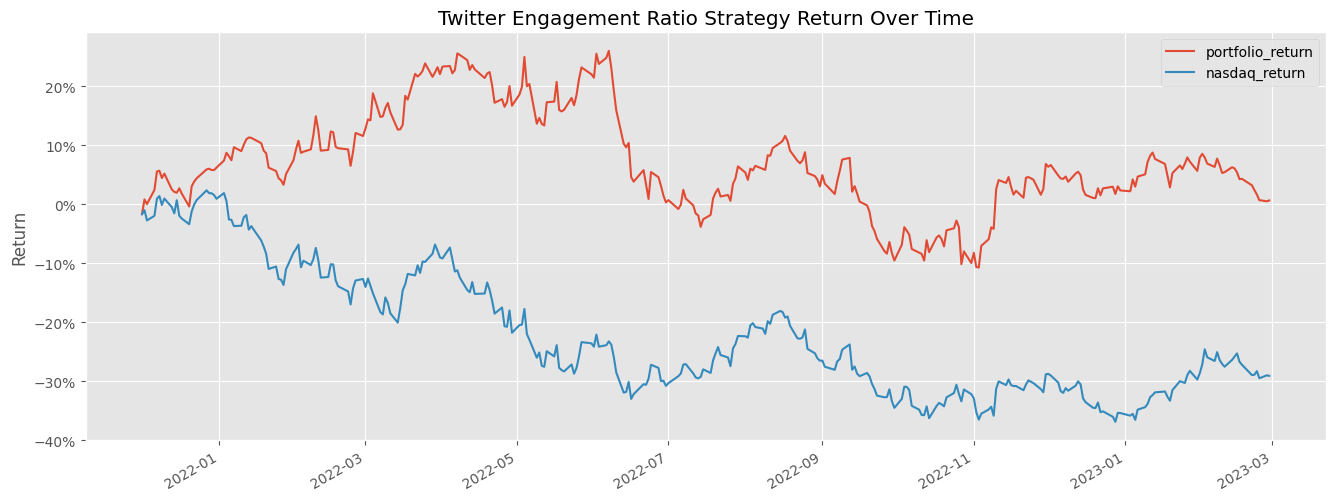

In [94]:
portfolios_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum()).sub(1)

portfolios_cumulative_return.plot(figsize=(16,6))

plt.title('Twitter Engagement Ratio Strategy Return Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()

# Intraday Strategy Using GARCH Model


* Using simulated daily data and intraday 5-min data.
* Load Daily and 5-minute data.
* Define function to fit GARCH model on the daily data and predict 1-day ahead volatility in a rolling window.
* Calculate prediction premium and form a daily signal from it.
* Merge with intraday data and calculate intraday indicators to form the intraday signal.
* Generate the position entry and hold until the end of the day.
* Calculate final strategy returns.



**1. Load Simulated Daily and Simulated 5-minute data.**
* I'm loading both datasets, set the indexes and calculate daily log returns.

In [ ]:
!pip install arch # install the arch module

In [103]:
from arch import arch_model

data_folder = '/content/simulated_daily_data.csv'

daily_df = pd.read_csv(data_folder)

daily_df = daily_df.drop('Unnamed: 7', axis=1)

daily_df['Date'] = pd.to_datetime(daily_df['Date'])

daily_df = daily_df.set_index('Date')

intraday_5min_df = pd.read_csv('/content/simulated_5min_data.csv')

intraday_5min_df = intraday_5min_df.drop('Unnamed: 6', axis=1)

intraday_5min_df['datetime'] = pd.to_datetime(intraday_5min_df['datetime'])

intraday_5min_df = intraday_5min_df.set_index('datetime')

intraday_5min_df['date'] = pd.to_datetime(intraday_5min_df.index.date)

intraday_5min_df

open         low        high       close  volume  \
datetime                                                                      
2021-09-29 20:00:00  10379.7775  10364.5950  10398.7025  10370.9575      46   
2021-09-29 20:05:00  10370.9425  10352.4175  10380.2500  10371.1450      53   
2021-09-29 20:10:00  10372.8150  10357.8250  10388.7500  10384.3125     116   
2021-09-29 20:15:00  10385.8275  10384.0825  10457.2000  10442.5175     266   
2021-09-29 20:20:00  10442.5225  10426.2375  10448.0000  10440.9950      65   
...                         ...         ...         ...         ...     ...   
2023-09-20 10:40:00   6792.1025   6783.6000   6796.2500   6790.1375      41   
2023-09-20 10:45:00   6790.5575   6779.1000   6795.7500   6781.9175      42   
2023-09-20 10:50:00   6781.5475   6779.3750   6790.2500   6783.9050      44   
2023-09-20 10:55:00   6783.9025   6779.9000   6793.2500   6782.0900      95   
2023-09-20 11:00:00   6783.7750   6774.3500   6787.5000   6778.6375      54   

                          date  
datetime                        
2021-09-29 20:00:00 2021-09-29  
2021-09-29 20:05:00 2021-09-29  
2021-09-29 20:10:00 2021-09-29  
2021-09-29 20:15:00 2021-09-29  
2021-09-29 20:20:00 2021-09-29  
...                        ...  
2023-09-20 10:40:00 2023-09-20  
2023-09-20 10:45:00 2023-09-20  
2023-09-20 10:50:00 2023-09-20  
2023-09-20 10:55:00 2023-09-20  
2023-09-20 11:00:00 2023-09-20  

[177877 rows x 6 columns]

**2. Define function to fit GARCH model and predict 1-day ahead volatility in a rolling window.**
* I'll first calculate the 6-month rolling variance and then I'll create a function in a 6-month rolling window to fit a garch model and predict the next day variance.

In [104]:
daily_df['log_ret'] = np.log(daily_df['Adj Close']).diff()

daily_df['variance'] = daily_df['log_ret'].rolling(180).var()

daily_df = daily_df['2020':]

def predict_volatility(x):

    best_model = arch_model(y=x,
                            p=1,
                            q=3).fit(update_freq=5,
                                     disp='off')

    variance_forecast = best_model.forecast(horizon=1).variance.iloc[-1,0]

    print(x.index[-1])

    return variance_forecast

daily_df['predictions'] = daily_df['log_ret'].rolling(180).apply(lambda x: predict_volatility(x))

daily_df = daily_df.dropna()

daily_df

2020-06-28 00:00:00
2020-06-29 00:00:00
2020-06-30 00:00:00
2020-07-01 00:00:00
2020-07-02 00:00:00
2020-07-03 00:00:00
2020-07-04 00:00:00
2020-07-05 00:00:00
2020-07-06 00:00:00
2020-07-07 00:00:00
2020-07-08 00:00:00
2020-07-09 00:00:00
2020-07-10 00:00:00
2020-07-11 00:00:00
2020-07-12 00:00:00
2020-07-13 00:00:00
2020-07-14 00:00:00
2020-07-15 00:00:00
2020-07-16 00:00:00
2020-07-17 00:00:00
2020-07-18 00:00:00
2020-07-19 00:00:00
2020-07-20 00:00:00
2020-07-21 00:00:00
2020-07-22 00:00:00
2020-07-23 00:00:00
2020-07-24 00:00:00


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2020-07-25 00:00:00
2020-07-26 00:00:00
2020-07-27 00:00:00
2020-07-28 00:00:00
2020-07-29 00:00:00
2020-07-30 00:00:00
2020-07-31 00:00:00
2020-08-01 00:00:00
2020-08-02 00:00:00
2020-08-03 00:00:00
2020-08-04 00:00:00
2020-08-05 00:00:00
2020-08-06 00:00:00
2020-08-07 00:00:00
2020-08-08 00:00:00
2020-08-09 00:00:00
2020-08-10 00:00:00
2020-08-11 00:00:00
2020-08-12 00:00:00
2020-08-13 00:00:00


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2020-08-14 00:00:00
2020-08-15 00:00:00
2020-08-16 00:00:00
2020-08-17 00:00:00
2020-08-18 00:00:00
2020-08-19 00:00:00
2020-08-20 00:00:00
2020-08-21 00:00:00
2020-08-22 00:00:00
2020-08-23 00:00:00
2020-08-24 00:00:00
2020-08-25 00:00:00
2020-08-26 00:00:00
2020-08-27 00:00:00
2020-08-28 00:00:00
2020-08-29 00:00:00
2020-08-30 00:00:00
2020-08-31 00:00:00
2020-09-01 00:00:00
2020-09-02 00:00:00
2020-09-03 00:00:00
2020-09-04 00:00:00
2020-09-05 00:00:00
2020-09-06 00:00:00
2020-09-07 00:00:00
2020-09-08 00:00:00
2020-09-09 00:00:00
2020-09-10 00:00:00
2020-09-11 00:00:00
2020-09-12 00:00:00
2020-09-13 00:00:00
2020-09-14 00:00:00
2020-09-15 00:00:00
2020-09-16 00:00:00
2020-09-17 00:00:00
2020-09-18 00:00:00
2020-09-19 00:00:00
2020-09-20 00:00:00
2020-09-21 00:00:00
2020-09-22 00:00:00
2020-09-23 00:00:00
2020-09-24 00:00:00
2020-09-25 00:00:00
2020-09-26 00:00:00
2020-09-27 00:00:00
2020-09-28 00:00:00
2020-09-29 00:00:00
2020-09-30 00:00:00
2020-10-01 00:00:00
2020-10-02 00:00:00


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2020-12-22 00:00:00
2020-12-23 00:00:00
2020-12-24 00:00:00
2020-12-25 00:00:00


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2020-12-26 00:00:00
2020-12-27 00:00:00
2020-12-28 00:00:00
2020-12-29 00:00:00
2020-12-30 00:00:00
2020-12-31 00:00:00
2021-01-01 00:00:00
2021-01-02 00:00:00
2021-01-03 00:00:00


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-01-04 00:00:00
2021-01-05 00:00:00
2021-01-06 00:00:00
2021-01-07 00:00:00


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-01-08 00:00:00
2021-01-09 00:00:00
2021-01-10 00:00:00


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-01-11 00:00:00
2021-01-12 00:00:00
2021-01-13 00:00:00
2021-01-14 00:00:00
2021-01-15 00:00:00
2021-01-16 00:00:00
2021-01-17 00:00:00
2021-01-18 00:00:00
2021-01-19 00:00:00
2021-01-20 00:00:00
2021-01-21 00:00:00
2021-01-22 00:00:00
2021-01-23 00:00:00
2021-01-24 00:00:00
2021-01-25 00:00:00
2021-01-26 00:00:00
2021-01-27 00:00:00
2021-01-28 00:00:00
2021-01-29 00:00:00
2021-01-30 00:00:00
2021-01-31 00:00:00
2021-02-01 00:00:00
2021-02-02 00:00:00
2021-02-03 00:00:00
2021-02-04 00:00:00
2021-02-05 00:00:00
2021-02-06 00:00:00
2021-02-07 00:00:00
2021-02-08 00:00:00
2021-02-09 00:00:00
2021-02-10 00:00:00
2021-02-11 00:00:00
2021-02-12 00:00:00
2021-02-13 00:00:00
2021-02-14 00:00:00
2021-02-15 00:00:00
2021-02-16 00:00:00
2021-02-17 00:00:00
2021-02-18 00:00:00
2021-02-19 00:00:00
2021-02-20 00:00:00
2021-02-21 00:00:00
2021-02-22 00:00:00
2021-02-23 00:00:00
2021-02-24 00:00:00
2021-02-25 00:00:00
2021-02-26 00:00:00
2021-02-27 00:00:00
2021-02-28 00:00:00
2021-03-01 00:00:00


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2021-03-17 00:00:00
2021-03-18 00:00:00
2021-03-19 00:00:00
2021-03-20 00:00:00
2021-03-21 00:00:00
2021-03-22 00:00:00
2021-03-23 00:00:00
2021-03-24 00:00:00
2021-03-25 00:00:00
2021-03-26 00:00:00
2021-03-27 00:00:00
2021-03-28 00:00:00
2021-03-29 00:00:00
2021-03-30 00:00:00
2021-03-31 00:00:00
2021-04-01 00:00:00
2021-04-02 00:00:00
2021-04-03 00:00:00
2021-04-04 00:00:00
2021-04-05 00:00:00
2021-04-06 00:00:00
2021-04-07 00:00:00
2021-04-08 00:00:00
2021-04-09 00:00:00
2021-04-10 00:00:00
2021-04-11 00:00:00
2021-04-12 00:00:00
2021-04-13 00:00:00
2021-04-14 00:00:00
2021-04-15 00:00:00
2021-04-16 00:00:00
2021-04-17 00:00:00
2021-04-18 00:00:00
2021-04-19 00:00:00
2021-04-20 00:00:00
2021-04-21 00:00:00
2021-04-22 00:00:00
2021-04-23 00:00:00
2021-04-24 00:00:00
2021-04-25 00:00:00
2021-04-26 00:00:00
2021-04-27 00:00:00
2021-04-28 00:00:00
2021-04-29 00:00:00
2021-04-30 00:00:00
2021-05-01 00:00:00
2021-05-02 00:00:00
2021-05-03 00:00:00
2021-05-04 00:00:00
2021-05-05 00:00:00


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2022-06-07 00:00:00
2022-06-08 00:00:00
2022-06-09 00:00:00
2022-06-10 00:00:00
2022-06-11 00:00:00
2022-06-12 00:00:00
2022-06-13 00:00:00
2022-06-14 00:00:00
2022-06-15 00:00:00
2022-06-16 00:00:00
2022-06-17 00:00:00
2022-06-18 00:00:00
2022-06-19 00:00:00
2022-06-20 00:00:00
2022-06-21 00:00:00
2022-06-22 00:00:00
2022-06-23 00:00:00
2022-06-24 00:00:00
2022-06-25 00:00:00
2022-06-26 00:00:00
2022-06-27 00:00:00
2022-06-28 00:00:00


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


2022-06-29 00:00:00
2022-06-30 00:00:00
2022-07-01 00:00:00
2022-07-02 00:00:00
2022-07-03 00:00:00
2022-07-04 00:00:00
2022-07-05 00:00:00
2022-07-06 00:00:00
2022-07-07 00:00:00
2022-07-08 00:00:00
2022-07-09 00:00:00
2022-07-10 00:00:00
2022-07-11 00:00:00
2022-07-12 00:00:00
2022-07-13 00:00:00
2022-07-14 00:00:00
2022-07-15 00:00:00
2022-07-16 00:00:00
2022-07-17 00:00:00
2022-07-18 00:00:00
2022-07-19 00:00:00
2022-07-20 00:00:00
2022-07-21 00:00:00
2022-07-22 00:00:00
2022-07-23 00:00:00
2022-07-24 00:00:00
2022-07-25 00:00:00
2022-07-26 00:00:00
2022-07-27 00:00:00
2022-07-28 00:00:00
2022-07-29 00:00:00
2022-07-30 00:00:00
2022-07-31 00:00:00
2022-08-01 00:00:00
2022-08-02 00:00:00
2022-08-03 00:00:00
2022-08-04 00:00:00
2022-08-05 00:00:00
2022-08-06 00:00:00
2022-08-07 00:00:00
2022-08-08 00:00:00
2022-08-09 00:00:00
2022-08-10 00:00:00
2022-08-11 00:00:00
2022-08-12 00:00:00
2022-08-13 00:00:00
2022-08-14 00:00:00
2022-08-15 00:00:00
2022-08-16 00:00:00
2022-08-17 00:00:00


Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-06-28  2262.115234  2299.386719  2243.881348  2285.895508  2285.895508   
2020-06-29  2285.007324  2309.393311  2260.468994  2297.713623  2297.713623   
2020-06-30  2296.395264  2304.458984  2271.209473  2284.498291  2284.498291   
2020-07-01  2286.496338  2327.438721  2276.183838  2307.081299  2307.081299   
2020-07-02  2307.784912  2318.740723  2259.155762  2280.852539  2280.852539   
...                 ...          ...          ...          ...          ...   
2023-09-14  6557.069336  6693.655762  6542.862793  6634.918457  6634.918457   
2023-09-15  6633.454590  6710.124512  6560.175293  6652.173340  6652.173340   
2023-09-16  6651.549805  6688.692383  6618.472656  6642.070313  6642.070313   
2023-09-17  6641.981934  6654.499512  6611.268555  6633.546875  6633.546875   
2023-09-18  6633.248535  6853.683594  6603.878906  6688.570313  6688.570313   

                  Volume   log_ret  variance  predictions  
Date                                                       
2020-06-28  1.456087e+10  0.010797  0.002473     0.000728  
2020-06-29  1.646055e+10  0.005157  0.002473     0.000651  
2020-06-30  1.573580e+10 -0.005768  0.002468     0.000877  
2020-07-01  1.597155e+10  0.009837  0.002455     0.000618  
2020-07-02  1.633892e+10 -0.011434  0.002456     0.000703  
...                  ...       ...       ...          ...  
2023-09-14  1.381136e+10  0.011801  0.000393     0.000334  
2023-09-15  1.147974e+10  0.002597  0.000385     0.000292  
2023-09-16  7.402031e+09 -0.001520  0.000384     0.000286  
2023-09-17  6.774211e+09 -0.001284  0.000383     0.000280  
2023-09-18  1.561534e+10  0.008261  0.000378     0.000298  

[1178 rows x 9 columns]

**3. Calculate prediction premium and form a daily signal from it.**
* I'll calculate the prediction premium.
* calculate its 6-month rolling standard deviation.

* From this I'll create my daily signal.

In [105]:
daily_df['prediction_premium'] = (daily_df['predictions']-daily_df['variance'])/daily_df['variance']

daily_df['premium_std'] = daily_df['prediction_premium'].rolling(180).std()

daily_df['signal_daily'] = daily_df.apply(lambda x: 1 if (x['prediction_premium']>x['premium_std'])
                                         else (-1 if (x['prediction_premium']<x['premium_std']*-1) else np.nan),
                                         axis=1)

daily_df['signal_daily'] = daily_df['signal_daily'].shift()

daily_df

Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-06-28  2262.115234  2299.386719  2243.881348  2285.895508  2285.895508   
2020-06-29  2285.007324  2309.393311  2260.468994  2297.713623  2297.713623   
2020-06-30  2296.395264  2304.458984  2271.209473  2284.498291  2284.498291   
2020-07-01  2286.496338  2327.438721  2276.183838  2307.081299  2307.081299   
2020-07-02  2307.784912  2318.740723  2259.155762  2280.852539  2280.852539   
...                 ...          ...          ...          ...          ...   
2023-09-14  6557.069336  6693.655762  6542.862793  6634.918457  6634.918457   
2023-09-15  6633.454590  6710.124512  6560.175293  6652.173340  6652.173340   
2023-09-16  6651.549805  6688.692383  6618.472656  6642.070313  6642.070313   
2023-09-17  6641.981934  6654.499512  6611.268555  6633.546875  6633.546875   
2023-09-18  6633.248535  6853.683594  6603.878906  6688.570313  6688.570313   

                  Volume   log_ret  variance  predictions  prediction_premium  \
Date                                                                            
2020-06-28  1.456087e+10  0.010797  0.002473     0.000728           -0.705556   
2020-06-29  1.646055e+10  0.005157  0.002473     0.000651           -0.736678   
2020-06-30  1.573580e+10 -0.005768  0.002468     0.000877           -0.644671   
2020-07-01  1.597155e+10  0.009837  0.002455     0.000618           -0.748362   
2020-07-02  1.633892e+10 -0.011434  0.002456     0.000703           -0.713818   
...                  ...       ...       ...          ...                 ...   
2023-09-14  1.381136e+10  0.011801  0.000393     0.000334           -0.151792   
2023-09-15  1.147974e+10  0.002597  0.000385     0.000292           -0.240810   
2023-09-16  7.402031e+09 -0.001520  0.000384     0.000286           -0.256793   
2023-09-17  6.774211e+09 -0.001284  0.000383     0.000280           -0.268903   
2023-09-18  1.561534e+10  0.008261  0.000378     0.000298           -0.211600   

            premium_std  signal_daily  
Date                                   
2020-06-28          NaN           NaN  
2020-06-29          NaN           NaN  
2020-06-30          NaN           NaN  
2020-07-01          NaN           NaN  
2020-07-02          NaN           NaN  
...                 ...           ...  
2023-09-14     0.549073           NaN  
2023-09-15     0.546370           NaN  
2023-09-16     0.545350           NaN  
2023-09-17     0.545207           NaN  
2023-09-18     0.544362           NaN  

[1178 rows x 12 columns]

**4. Merge with intraday data and calculate intraday indicators to form the** intraday signal.
* Calculate all intraday indicators and intraday signal.

In [106]:
final_df = intraday_5min_df.reset_index()\
                            .merge(daily_df[['signal_daily']].reset_index(),
                                   left_on='date',
                                   right_on='Date')\
                            .drop(['date','Date'], axis=1)\
                            .set_index('datetime')

final_df['rsi'] = pandas_ta.rsi(close=final_df['close'],
                                length=20)

final_df['lband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,0]

final_df['uband'] = pandas_ta.bbands(close=final_df['close'],
                                     length=20).iloc[:,2]

final_df['signal_intraday'] = final_df.apply(lambda x: 1 if (x['rsi']>70)&
                                                            (x['close']>x['uband'])
                                             else (-1 if (x['rsi']<30)&
                                                         (x['close']<x['lband']) else np.nan),
                                             axis=1)

final_df['return'] = np.log(final_df['close']).diff()

final_df

open         low        high       close  volume  \
datetime                                                                      
2021-09-29 20:00:00  10379.7775  10364.5950  10398.7025  10370.9575      46   
2021-09-29 20:05:00  10370.9425  10352.4175  10380.2500  10371.1450      53   
2021-09-29 20:10:00  10372.8150  10357.8250  10388.7500  10384.3125     116   
2021-09-29 20:15:00  10385.8275  10384.0825  10457.2000  10442.5175     266   
2021-09-29 20:20:00  10442.5225  10426.2375  10448.0000  10440.9950      65   
...                         ...         ...         ...         ...     ...   
2023-09-18 23:35:00   6708.0025   6705.5175   6712.0000   6708.8675      11   
2023-09-18 23:40:00   6708.8650   6707.1800   6714.2500   6709.3350      22   
2023-09-18 23:45:00   6709.9250   6704.3600   6713.5000   6708.2750      25   
2023-09-18 23:50:00   6708.2750   6705.7700   6712.7500   6705.8050      11   
2023-09-18 23:55:00   6705.8025   6705.3875   6712.0000   6706.8875       6   

                     signal_daily        rsi        lband        uband  \
datetime                                                                 
2021-09-29 20:00:00           NaN        NaN          NaN          NaN   
2021-09-29 20:05:00           NaN        NaN          NaN          NaN   
2021-09-29 20:10:00           NaN        NaN          NaN          NaN   
2021-09-29 20:15:00           NaN        NaN          NaN          NaN   
2021-09-29 20:20:00           NaN        NaN          NaN          NaN   
...                           ...        ...          ...          ...   
2023-09-18 23:35:00           NaN  62.861699  6677.365065  6715.855435   
2023-09-18 23:40:00           NaN  63.165869  6679.544207  6716.559793   
2023-09-18 23:45:00           NaN  61.954798  6682.379916  6716.534084   
2023-09-18 23:50:00           NaN  59.172065  6685.549735  6715.801265   
2023-09-18 23:55:00           NaN  60.000874  6687.480314  6715.772186   

                     signal_intraday    return  
datetime                                        
2021-09-29 20:00:00              NaN       NaN  
2021-09-29 20:05:00              NaN  0.000018  
2021-09-29 20:10:00              NaN  0.001269  
2021-09-29 20:15:00              NaN  0.005589  
2021-09-29 20:20:00              NaN -0.000146  
...                              ...       ...  
2023-09-18 23:35:00              NaN  0.000128  
2023-09-18 23:40:00              NaN  0.000070  
2023-09-18 23:45:00              NaN -0.000158  
2023-09-18 23:50:00              NaN -0.000368  
2023-09-18 23:55:00              NaN  0.000161  

[177456 rows x 11 columns]

**5. Generate the position entry and hold until the end of the day.**


In [107]:
final_df['return_sign'] = final_df.apply(lambda x: -1 if (x['signal_daily']==1)&(x['signal_intraday']==1)
                                        else (1 if (x['signal_daily']==-1)&(x['signal_intraday']==-1) else np.nan),
                                        axis=1)

final_df['return_sign'] = final_df.groupby(pd.Grouper(freq='D'))['return_sign']\
                                  .transform(lambda x: x.ffill())

final_df['forward_return'] = final_df['return'].shift(-1)

final_df['strategy_return'] = final_df['forward_return']*final_df['return_sign']

daily_return_df = final_df.groupby(pd.Grouper(freq='D'))['strategy_return'].sum()

**6. Calculate final strategy returns.**


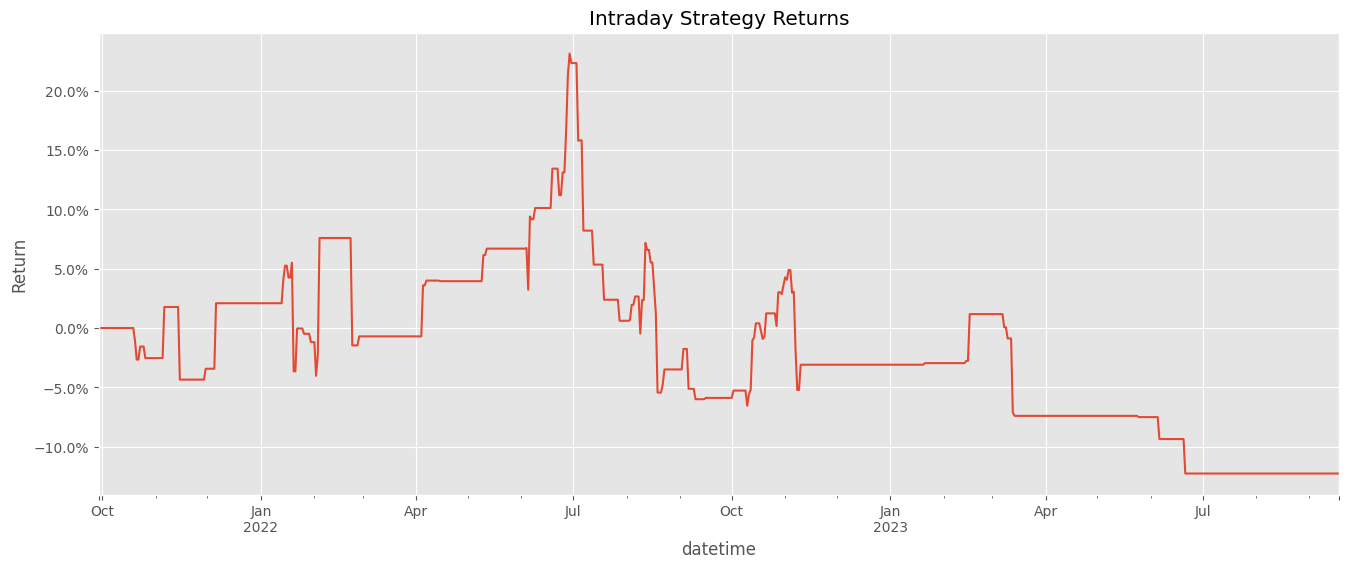

In [108]:
import matplotlib.ticker as mtick

strategy_cumulative_return = np.exp(np.log1p(daily_return_df).cumsum()).sub(1)

strategy_cumulative_return.plot(figsize=(16,6))

plt.title('Intraday Strategy Returns')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()